In [1]:
import warnings
warnings.filterwarnings('ignore')
import gc
gc.collect()

416

In [2]:
# imports
import random
import datetime
#from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import re
import requests
import xml.etree.ElementTree as ET
from scipy import interpolate
from matplotlib.backends.backend_pdf import PdfPages
from dask import dataframe as dd
import time
import datetime as dt
#import pickleloc
from pandas import read_csv
from typing import List
import os
import plotly
import cufflinks as cf
cf.go_offline(connected=False)
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller

plt.rcParams['figure.figsize'] = [17, 5]
plt.rcParams['figure.dpi'] = 100 #

pd.set_option('display.max_columns', 15)  
pd.options.display.max_rows = 20
pd.options.display.float_format = '{:.3f}'.format


## 1.Step

In [3]:
# initial functions
def get_near_next_from_current(current):# get nearest and next days from current day    
    bnear = False
    for i in range(23, 37):
        nextday = pd.Timestamp(current) + pd.Timedelta('{} days'.format(i))
        if nextday.weekday() == 4:
            if not bnear:
                bnear = True
                near_date = '{:4d}-{:02d}-{:02d}'.format(nextday.year, nextday.month, nextday.day)
            else:
                next_date = '{:4d}-{:02d}-{:02d}'.format(nextday.year, nextday.month, nextday.day)
    
    return near_date, next_date


def make_normal_from_data(dataframe) :# drop unuseful columns and rename 
    data = dataframe
    data = data.drop(columns=['underlying_symbol', 'root','open', 'high', 'low', 'close', 'trade_volume','vega','rho','theta', 'gamma','underlying_bid',
       'underlying_ask', 'implied_underlying_price', 'active_underlying_price',
       'implied_volatility', 'delta', 'gamma', 'theta', 'vega', 'rho'])
    #(data.columns)
    data = data.rename(columns = {'expiration' : 'expiry', 'option_type' : 'call_put', 
                                 'bid' : 'bid_price', 'ask' : 'ask_price'})#'quote_datetime': 'datetime', 
    #print(data.columns)
    #data['datetime'] = pd.to_datetime(data['datetime'])
    data['strike'] = data['strike'].apply(int)
    #data = data.set_index('datetime')
    return data

def get_column(col):
    if len(col) == 28: 
        return col[0:9]
    else:
        return col[0:10]

def get_coltoint(col):
    if len(col) == 25: 
        return col[2:6]
    else:
        return col[2:5]
    
def add_seconds_to_expiry(data, near):
    data['time'] = data.index
    data[['h', 'm', 's']] = [(x.hour, x.minute, x.second) for x in data['time']]
    data[['date']] = [(x.date()) for x in data['time']]
    data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d')
    data['rem_mins_day_end'] = (23-data['h']) * 60 + (60 - data['m'])
    data['rem_full_days'] = pd.to_datetime([x for x in data['expiry']]) - data['date'] - pd.Timedelta(1, unit='d')
    data['expiry_days'] = ((pd.to_datetime([x for x in data['expiry']]) - data['date']) / pd.Timedelta(1, unit='d')).apply(int)
    if near:
        data['rem_mins'] = data['rem_mins_day_end'] + data['rem_full_days'] / pd.Timedelta('1 minute') + 510  
    else:
        data['rem_mins'] = data['rem_mins_day_end'] + data['rem_full_days'] / pd.Timedelta('1 minute') + 900
    data['T'] = data['rem_mins'] / 525600
    
    data.drop(columns=['time', 'h', 'm', 's', 'date', 'rem_mins_day_end', 'rem_full_days'], inplace=True)
    return data
def make_min_put_call_dif(x):
    x['min_put_call_value'] = 0
    for i in range(0, len(x) - 1):
        x['min_put_call_value'].iloc[i] = x[x['col_with_min_mid_price_abs_diff'].iloc[i]].iloc[i]
    return x

def make_df_memory_efficient(df):
    print(df.info())
    float_col = df.select_dtypes(include=['float64']) # This will select float columns only
    for col in float_col.columns.values[1:1]:
        df[col] = pd.to_numeric(df[col], downcast= 'float')

    float_col = df.select_dtypes(include=['object']) # This will select float columns only
    for col in float_col.columns.values:
        df[col] = df[col].astype('category')
    print(df.memory_usage(deep=True))
    return df


def optimize_floats(df: pd.DataFrame) -> pd.DataFrame:
    floats = df.select_dtypes(include=['float64']).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    return df


def optimize_ints(df: pd.DataFrame) -> pd.DataFrame:
    ints = df.select_dtypes(include=['int64']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    return df


def optimize_objects(df: pd.DataFrame, datetime_features: List[str]) -> pd.DataFrame:
    for col in df.select_dtypes(include=['object']):
        if col not in datetime_features:
            df[col] = df[col].astype('category')
        else:
            df[col] = pd.to_datetime(df[col])
    return df

def optimize(df: pd.DataFrame, datetime_features: List[str] = []):
    
    df = optimize_floats(optimize_ints(optimize_objects(df, datetime_features)))
    return df

def create_col_names_from_unique_values(x):

    option_name = str(x['call_put'].unique()[0] + '_' + str(int(x['strike'].unique()))
                      + '_' + str(int(x['expiry_days'].unique())
                                  ) + 'd'
                      )
    col_names = list()
    col_suffixes = ['_call_put', '_strike', '_expiry_days', '_orig_bid_price', '_bid_price', '_ask_price',
                    '_mid_price']
    for col_suffix in col_suffixes:
        col_names.append(option_name + col_suffix)
    return col_names

def create_relevant_data(x, col_names):
    x.rename(columns={'call_put': col_names[0]}, inplace=True)
    x.rename(columns={'strike': col_names[1]}, inplace=True)
    x.rename(columns={'expiry_days': col_names[2]}, inplace=True)
    x.rename(columns={'orig_bid_price': col_names[3]}, inplace=True)
    x.rename(columns={'bid_price': col_names[4]}, inplace=True)
    x.rename(columns={'ask_price': col_names[5]}, inplace=True)
    x.rename(columns={'mid_price': col_names[6]}, inplace=True)

    return x[col_names]

def get_value(x):
    if len(x) == 9:
        return x[2:5]
    else:
        return x[2:6]
    
def find_K_0_from_forward(forward, strikes):
    strikes = np.extract(strikes <= forward, strikes)
    K_0 = np.max(strikes)
    return K_0

def add_expiry_days(data):
    data['expiry_days'] = (pd.to_datetime([x for x in data['expiry']]) - pd.to_datetime([(x.date()) for x in data.index])) /  pd.Timedelta(1, unit='d')
    data['expiry_days'] = data['expiry_days'].apply(int)
    return data

def getImpliedVolatilityForSPX(spx):
    df = spx[spx['option_type'] == 'C']
    df['ATM'] = df['strike'] / df['SP500 price']
    df['ATM'] = df['ATM'].apply(math.log)
    
    dfret = df[(df['ATM'] >= -0.03) & (df['ATM'] < 0.03)]
    
    dfret = dfret.groupby(['quote_datetime']).mean()
    dfret = pd.concat([dfret['implied_volatility']], axis = 1)
    return dfret

def getImpliedVolatilityForVIX(vix):
    df = vix[vix['option_type'] == 'C']
    df['ATM'] = df['strike'] / df['active_underlying_price']
    df['ATM'] = df['ATM'].apply(math.log)
    
    dfret = df[(df['ATM'] >= -0.03) & (df['ATM'] < 0.03)]
    
    dfret = dfret.groupby(['quote_datetime']).mean()
    dfret = pd.concat([dfret['implied_volatility']], axis = 1)
    return dfret

def resampleforminute(dfsrc, colname):
    df = dfsrc
    dfdst = dfsrc
    
    for i in range(0, len(df) - 1):
        delta = (pd.to_datetime(df[colname][i + 1]) - pd.to_datetime(df[colname][i])) / pd.Timedelta(1, unit='min')
        
        if delta == 1.0:
            continue
        
        #print(delta)
        nlen = math.floor(delta)
        dlist = []
        for j in range(1, nlen):
            date1 = str(pd.to_datetime(df[colname][i]) + pd.Timedelta(1, unit='min') * j)
            bid1 = (df['BID_PRICE'][i + 1] - df['BID_PRICE'][i]) * j / nlen + df['BID_PRICE'][i]
            ask1 = (df['ASK_PRICE'][i + 1] - df['ASK_PRICE'][i]) * j / nlen + df['ASK_PRICE'][i]
            thou1 = (df['ENTRY_TIME THOU'][i + 1] - df['ENTRY_TIME THOU'][i]) * j / nlen + df['ENTRY_TIME THOU'][i]
            dlist.append([date1, bid1, ask1, thou1])
        
        dftemp = pd.DataFrame(dlist)
        dftemp.columns = ['date', 'BID_PRICE', 'ASK_PRICE', 'ENTRY_TIME THOU']
        
        dfdst = pd.concat([dfdst, dftemp])
        #print(dfdst)
    return dfdst

In [4]:
def getNear_Next(df, near, near_date):
    df = add_seconds_to_expiry(df, near)
    df['mid_price'] = (df['bid_price'] + df['ask_price']) / 2
    df['orig_bid_price'] = df['bid_price']
    df.loc[df['bid_price'] == 0, 'mid_price'] = 0
    df.loc[df['bid_price'] == 0, 'ask_price'] = 0
    df = optimize(df)
    
    data_by_option = df.groupby(['call_put', 'strike', 'expiry_days'])
    raw_grouped_data = [data_by_option.get_group(x) for x in data_by_option.groups]
    grouped_data     = [x for x in raw_grouped_data]
    col_names_list     = [create_col_names_from_unique_values(x) for x in grouped_data]
    vix_data_option_list     = [create_relevant_data(x, y) for x, y in zip(grouped_data, col_names_list)]
    vix_data     = pd.concat(vix_data_option_list, axis=1)
    vix_data     = optimize(vix_data)
    original_bid_price_col_names      = [col for col in vix_data.columns if (('d_orig_bid_price' in col) )]
    bid_price_col_names      = [col for col in vix_data.columns if (('d_bid_price' in col) )]
    ask_price_col_names      = [col for col in vix_data.columns if (('d_ask_price' in col) )]
    mid_price_col_names      = [col for col in vix_data.columns if (('d_mid_price' in col) )]
    mins_from_near_to_next = 7 * 24 * 60
    vix_data['mins_from_near_to_next'] = mins_from_near_to_next
    vix_data['expiry']     = near_date.replace('-','')
    vix_data     = add_seconds_to_expiry(vix_data, near)
    r = 0.02
    vix_data['discount']     = np.exp(r * vix_data['T'])
    put_mid_price_col_names      = [col for col in vix_data.columns if (('d_mid_price' in col) & ('P_' in col) & ('_diff' not in col))]
    mid_price_col_names          = [col for col in vix_data.columns if (('d_mid_price' in col) & ('_diff' not in col))]
    # Compute the differences between the mid price for a put and a call, same strike, same expiry
    # We need to consider that there might be a strike where either only put or call is available (3300 e.g. in the dataset for Feb 5)
    call_mid_price_col_names = []
    for put_mid_price_col_name in put_mid_price_col_names:
        # go through all put names; add the corresponding call name; test if this column exists in the data
        try:
            put_mid_price = vix_data[put_mid_price_col_name]
        except:
            put_mid_price_col_names.remove(put_mid_price_col_name)
            try:
                vix_data.drop(put_mid_price_col_name, inplace=True, axis=1)
            except:
                print('col already removed')

            print('skipping: ' + put_mid_price_col_name)
            print('trying to remove: ' + put_mid_price_col_name)
            continue

        call_mid_price_col_name = put_mid_price_col_name
        call_mid_price_col_name = call_mid_price_col_name.replace('P', 'C')

        try:
            call_mid_price = vix_data[call_mid_price_col_name]

        except:
            print('skipping: ' + call_mid_price_col_name)
            print('trying to remove: ' + put_mid_price_col_name)
            put_mid_price_col_names.remove(put_mid_price_col_name)
            try:
                vix_data.drop(put_mid_price_col_name, inplace=True, axis=1)

            except:
                print('col already removed')

            continue
        mid_price_diff_col_name = put_mid_price_col_name + '_diff'
        mid_price_abs_diff_col_name = put_mid_price_col_name + '_abs_diff'

        vix_data[mid_price_diff_col_name] = call_mid_price - put_mid_price  # as per VIX white paper
        vix_data[mid_price_abs_diff_col_name] = vix_data[mid_price_diff_col_name].apply(abs)
    put_mid_price_col_names      = [col[0:40] for col in vix_data.columns if (('d_mid_price' in col) & ('abs_diff' in col))]
    call_mid_price_col_names      = [x.replace('P', 'C') for x in put_mid_price_col_names]
    put_call_mid_price_col_names      = call_mid_price_col_names + put_mid_price_col_names
    option_names      = [get_column(col) for col in put_call_mid_price_col_names]

    # We generate additional column names from our table, e.g. all columns which are for the mid prices
    # option_names
    call_strike_col_names                = [col + '_strike' for col in option_names if ('C_' in col)]
    call_otm_col_names                   = [col + '_otm' for col in option_names if ('C_' in col)]
    put_otm_col_names                    = [col + '_otm' for col in option_names if ('P_' in col)]
    otm_col_names                        = [col + '_otm' for col in option_names]
    put_strike_col_names                 = [col + '_strike' for col in option_names if ('P_' in col)]
    call_strike_col_names                = [col + '_strike' for col in option_names if ('C_' in col)]
    otm_col_names                        = [col + '_otm' for col in option_names]
    call_otm_col_names                   = [col + '_otm' for col in option_names if ('C_' in col)]
    put_otm_col_names                    = [col + '_otm' for col in option_names if ('P_' in col)]
    bid_price_col_names                  = [col + '_bid_price' for col in option_names]
    strike_col_names                     = [col + '_strike' for col in option_names]
    bid_price_col_names                  = [col + '_bid_price' for col in option_names]
    original_bid_price_col_names         = [col + '_orig_bid_price' for col in option_names]
    put_bid_price_col_names              = [col + '_bid_price' for col in option_names if ('P_' in col)]
    call_bid_price_col_names             = [col + '_bid_price' for col in option_names if ('C_' in col)]
    strike_col_names                     = [col + '_strike' for col in option_names]
    contribution_col_names               = [col + '_contribution' for col in option_names]
    contribution_sqrt_col_names          = [col + '_contribution_sqrt' for col in option_names]
    # we need the actual columns now to be used from vix data
    mid_price_col_names                  = [col + '_mid_price' for col in option_names]
    put_mid_price_col_names              = [col + '_mid_price' for col in option_names if ('P_' in col)]
    call_mid_price_col_names             = [col + '_mid_price' for col in option_names if ('C_' in col)]
    call_bid_price_col_names             = [col + '_bid_price' for col in option_names if ('C_' in col)]
    delta_strike_col_names               = [col + '_delta_strike' for col in option_names]
    strike_col_names                     = [col + '_strike' for col in option_names]
    contribution_col_names               = [col + '_contrib' for col in option_names]
    sigma_squared_contribution_col_names = [col + '_sigma_sq_contrib' for col in option_names]
    sigma_contribution_col_names         = [col + '_sigma_contrib' for col in option_names]
    settlement_weight_col_names          = [col + '_settle_wgt' for col in option_names]
    additive_scaled_col_names            = [col + '_additive_scaled' for col in option_names]
    mid_price_diff_col_names             = [col + '_mid_price_diff' for col in option_names if ('P_' in col)]
    mid_price_abs_diff_col_names         = [col + '_mid_price_abs_diff' for col in option_names if ('P_' in col)]
    put_delta_strike_col_names           = [col + '_delta_strike' for col in option_names if ('P_' in col)]
    call_delta_strike_col_names          = [col + '_delta_strike' for col in option_names if ('C_' in col)]
    put_strike_col_names                 = [col + '_strike' for col in option_names if ('P_' in col)]
    call_strike_col_names                = [col + '_strike' for col in option_names if ('C_' in col)]
    strike_weight_col_names              = [col + '_strike_wgt' for col in option_names]
    strike_weight_times_mid_col_names    = [col + '_strike_wgt_mid' for col in option_names]
    mid_price_col_names                  = [col + '_mid_price' for col in option_names if ('_diff' not in col)]
    put_mid_price_col_names              = [col + '_mid_price' for col in option_names if (('_diff' not in col) & ('P_' in col))]
    is_zero_bid_col_names                = [col + '_is_zero_bid' for col in option_names]
    is_second_zero_bid_col_names         = [col + '_is_second_zero_bid' for col in option_names]
    is_second_zero_put_bid_col_names     = [col + '_is_second_zero_bid' for col in option_names if ('P_' in col)]
    is_second_zero_call_bid_col_names    = [col + '_is_second_zero_bid' for col in option_names if ('C_' in col)]
    is_after_two_zero_bid_col_names      = [col + '_is_after_two_zero_bid' for col in option_names]
    mid_price_with_two_zero_bid_col_names = [col + '_mid_price_with_two_zero_bid' for col in option_names]
    strike_with_NA_col_names             = [col + '_strike_with_NA' for col in option_names]
    put_strike_with_NA_col_names         = [col + '_strike_with_NA' for col in option_names if ('P_' in col)]
    call_strike_with_NA_col_names        = [col + '_strike_with_NA' for col in option_names if ('C_' in col)]
    call_bid_sum_two_adjacents_col_names = [col + '_bid_sum_two_adjacent' for col in option_names if ('C_' in col)]
    put_bid_sum_two_adjacents_col_names  = [col + '_bid_sum_two_adjacent' for col in option_names if ('P_' in col)]
    vix_data[original_bid_price_col_names]          = vix_data[bid_price_col_names]
    vix_data['col_with_min_mid_price_abs_diff']     = vix_data[mid_price_diff_col_names].apply(abs).idxmin(axis=1)
    vix_data['min_mid_price_abs_diff']     = vix_data[mid_price_diff_col_names].apply(abs).min(axis=1)
    vix_data = make_min_put_call_dif(vix_data)
    
    vix_data['min_mid_price_diff_strike'] = vix_data['col_with_min_mid_price_abs_diff'].astype(str).apply(get_coltoint).apply(int)
    vix_data['raw_forward'] = vix_data['min_mid_price_diff_strike'] + vix_data['discount'] * vix_data['min_put_call_value']
    unique_strikes      = pd.unique([int(get_value(x)) for x in option_names])
    vix_data['forward'] = vix_data['raw_forward']
    K_0      = pd.Series([find_K_0_from_forward(x, unique_strikes) for x in vix_data['forward']])
    K_0.loc[K_0.diff() > 80] = np.NaN
    K_0.loc[K_0.diff() < -80] = np.NaN
    K_0.ffill(inplace=True)
    K_0.bfill(inplace=True)
    K_0.index = vix_data.index
    vix_data['K_0'] = K_0
    for call_strike_col_name, call_otm_col_name in zip(call_strike_col_names, call_otm_col_names):
        vix_data[call_otm_col_name] = vix_data[call_strike_col_name] >= vix_data['K_0']
    for put_strike_col_name, put_otm_col_name in zip(put_strike_col_names, put_otm_col_names):
        vix_data[put_otm_col_name] = vix_data[put_strike_col_name] <= vix_data['K_0']
    for bid_price_col_name, mid_price_col_name, otm_col_name in zip(bid_price_col_names, mid_price_col_names,otm_col_names):
        vix_data.loc[vix_data[otm_col_name] == False, bid_price_col_name] = np.NaN
        vix_data.loc[vix_data[otm_col_name] == False, mid_price_col_name] = np.NaN
    for mid_price_col_name, bid_price_col_name in zip(mid_price_col_names, bid_price_col_names):
        vix_data.loc[vix_data[bid_price_col_name] == 0, mid_price_col_name] = np.NaN

    put_bid_prices = vix_data[put_bid_price_col_names]
    call_bid_prices = vix_data[call_bid_price_col_names]
    put_bid_prices_sum_two_neighbours              = put_bid_prices +  put_bid_prices.shift(-1, axis=1)
    vix_data[put_bid_sum_two_adjacents_col_names]  = put_bid_prices_sum_two_neighbours
    call_bid_prices_sum_two_neighbours             = call_bid_prices +  call_bid_prices.shift(-1, axis=1)
    vix_data[call_bid_sum_two_adjacents_col_names] = call_bid_prices_sum_two_neighbours

    for is_second_zero_put_bid_col_name, put_bid_sum_two_adjacents_col_name in zip(is_second_zero_put_bid_col_names, put_bid_sum_two_adjacents_col_names):
        vix_data.loc[vix_data[put_bid_sum_two_adjacents_col_name] == 0, is_second_zero_put_bid_col_name] = True
    for is_second_zero_call_bid_col_name, call_bid_sum_two_adjacents_col_name in zip(is_second_zero_call_bid_col_names, call_bid_sum_two_adjacents_col_names):
        vix_data.loc[vix_data[call_bid_sum_two_adjacents_col_name] == 0, is_second_zero_call_bid_col_name] = True

    vix_data[is_second_zero_call_bid_col_names] = vix_data[is_second_zero_call_bid_col_names].ffill(axis=1) #we fill True values to the right, increasing strikes; the other values are still NAs, so only True gets forward filled
    vix_data[is_second_zero_put_bid_col_names]  = vix_data[is_second_zero_put_bid_col_names].bfill(axis=1) #for put strikes we go to smaller values
    
    for is_second_zero_bid_col_name, bid_price_col_name, mid_price_col_name in zip(is_second_zero_bid_col_names, bid_price_col_names, mid_price_col_names):
        vix_data.loc[vix_data[is_second_zero_bid_col_name] == True, mid_price_col_name] = np.NaN
    vix_data[strike_with_NA_col_names]          = vix_data[strike_col_names]
    for mid_price_col_name, strike_with_NA_col_name in zip(mid_price_col_names, strike_with_NA_col_names):
        vix_data.loc[vix_data[mid_price_col_name] == 0, strike_with_NA_col_name] = np.NaN
        vix_data.loc[vix_data[mid_price_col_name].isnull(), strike_with_NA_col_name] = np.NaN
    
    put_strikes      = vix_data[put_strike_with_NA_col_names]
    call_strikes      = vix_data[call_strike_with_NA_col_names]
    put_delta_strikes = (put_strikes.shift(-1, axis = 1).ffill(axis = 1) - put_strikes.shift(1, axis = 1).bfill(axis = 1))/2
    put_delta_strikes.iloc[:, 0] = put_delta_strikes.iloc[:, 0] * 2
    put_delta_strikes.columns = put_delta_strike_col_names
    call_delta_strikes            = (call_strikes.shift(-1, axis = 1).bfill(axis = 1) - call_strikes.shift(1, axis = 1).ffill(axis = 1))/2
    call_delta_strikes.iloc[:, 0] = call_delta_strikes.iloc[:, 0] * 2
    call_delta_strikes.columns    = call_delta_strike_col_names
    vix_data     = vix_data.join(put_delta_strikes, how = 'right')
    vix_data     = vix_data.join(call_delta_strikes, how = 'right')
    vix_data['additive']     = 1 / vix_data['T'] * (vix_data['forward'] / vix_data['K_0'] - 1).pow(2)
    number_of_relevant_options      = (vix_data[mid_price_col_names] > 0).sum(axis=1)  
    number_of_relevant_options.name = 'number_of_relevant_options'
    vix_data['number_of_relevant_options']     = number_of_relevant_options
    number_of_OTM_options      = (vix_data[otm_col_names] == True).sum(axis=1)  
    number_of_OTM_options.name = 'number_of_OTM_options'
    vix_data['number_of_OTM_options']     = number_of_OTM_options
    vix_data['N_T']       = vix_data['rem_mins'] 
    vix_data['N_30']      = 43200.0
    vix_data['N_365']     = 525600.0
    for additive_scaled_col_name, strike_with_NA_col_name, contribution_col_name, contribution_sqrt_col_name, sigma_squared_contribution_col_name, sigma_contribution_col_name, mid_price_col_name, delta_strike_col_name, settlement_weight_col_name, strike_weight_col_name, strike_weight_times_mid_col_name in zip(additive_scaled_col_names, strike_with_NA_col_names, contribution_col_names,  contribution_sqrt_col_names,sigma_squared_contribution_col_names, sigma_contribution_col_names, mid_price_col_names, delta_strike_col_names, settlement_weight_col_names, strike_weight_col_names, strike_weight_times_mid_col_names):
        vix_data[strike_weight_col_name] = vix_data[delta_strike_col_name] / (vix_data[strike_with_NA_col_name].pow(2))
        vix_data[strike_weight_times_mid_col_name] = vix_data[strike_weight_col_name] * vix_data[mid_price_col_name]
        vix_data[sigma_squared_contribution_col_name] = vix_data[strike_weight_col_name] * vix_data[mid_price_col_name] * \
            vix_data['discount'] * 2 / vix_data['T'] 
    vix_data['sigma_squared'] = vix_data[strike_weight_times_mid_col_names].sum(axis=1) * vix_data['discount'] * 2 / vix_data['T'] - vix_data['additive']
    vix_data['sigma_squared_under_sqrt_unweighted'] = vix_data['sigma_squared'] * vix_data['T']  * vix_data['N_365'] / vix_data['N_30'] * 10000
    return vix_data

In [5]:
def filtering(vix_data):
    published_vix = []
    base_line = []
    time_passed = []
    start_vix = vix_data["vix"][0]
    time_of_new_base = vix_data.index[0]  # start time
    #published_vix = vix_data["VIX_no_filtering"][0]
    base = vix_data["vix"][0]  # initialize, if there is no base yet
    for index, vix in vix_data["vix"].iteritems():

        # initialize, if there is no base yet

        new_time_passed = (index - time_of_new_base)/pd.Timedelta(1, unit='min')

        if(vix > base+0.49):
           # if(new_time_passed> 2):
            new_published_vix = vix
            base = vix
            time_of_new_base = index
        # else:
        #    new_published_vix = base

        elif(vix < base-0.49):
            if(new_time_passed > 2):
                new_published_vix = vix
                base = vix
                time_of_new_base = index
            else:
                new_published_vix = base
        else:
            new_published_vix = vix

        base_line.append(base)
        published_vix.append(new_published_vix)
        time_passed.append(new_time_passed)
    published_vix = pd.DataFrame(published_vix, index=vix_data.index, columns=["published_vix"])
    base_line = pd.DataFrame(base_line, index=vix_data.index, columns=["base_line"])
    time_passed = pd.DataFrame(time_passed, index=vix_data.index, columns=["time_passed"])
    
    df = pd.concat([time_passed, vix_data["vix"], published_vix, base_line], axis=1)#.head(20)
    return df

### $ \sigma_1^2 =  \frac{2}{T_1}\sum_{i}^{}\frac{\Delta K_i}{K_i^2} e^{R_1T_1} Q(K_i) - \frac{1}{T_1} \left [ \frac{F_1}{K_0} - 1 \right]  ^ 2$
### $ \sigma_2^2 =  \frac{2}{T_2}\sum_{i}^{}\frac{\Delta K_i}{K_i^2} e^{R_2T_2} Q(K_i) - \frac{1}{T_2} \left [ \frac{F_2}{K_0} - 1 \right]  ^ 2$
### VIX = 100$\mathsf X \sqrt{ \{T_1\sigma_1^2 \left[ \frac{N_{T_{2}}- N_{30}}{N_{T_{2}}- N_{T_{1}}} \right]\}+T_2\sigma_2^2 \left[ \frac{N_{30}-N_{T_{2}} }{N_{T_{2}}- N_{T_{1}}} \right]\}\mathsf X \frac{N_{365}}{N_{30}}}$

In [6]:
def getVix(date, df):
    [neardate, nextdate] = get_near_next_from_current(date)
    
    dfnear = df[(df['expiration'] == neardate) & (df['root'] == 'SPXW')]
    dfnext = df[(df['expiration'] == nextdate) & (df['root'] == 'SPXW')]
    #dfnear = df[(df['expiration'] == neardate)]
    #dfnext = df[(df['expiration'] == nextdate)]
    dfnext1 = pd.DataFrame()
    
    if dfnear.empty:
        dfnear = dfnext
        dfnext = pd.DataFrame()
    
    start = date + ' 08:31:00'
    end = date + ' 14:14:00'
    
    dfnear = make_normal_from_data(dfnear)
    dfnear1 = dfnear.loc[start:end]
    dfnear1 = add_seconds_to_expiry(dfnear1, True)
    vix_data = getNear_Next(dfnear1, True, neardate)
    
    if dfnext.empty == False:
        dfnext = make_normal_from_data(dfnext)
        dfnext1 = dfnext.loc[start:end]    
    
    if dfnext1.empty:
        #vix_data['sigma_squared_weight_near'] = (vix_data['N_T'] - vix_data['N_30']) / (vix_data['mins_from_near_to_next']) 
        vix_data['sigma_squared_under_sqrt'] = abs(vix_data['sigma_squared_under_sqrt_unweighted'])# * vix_data['sigma_squared_weight_near'])
    else:
        dfnext1 = add_seconds_to_expiry(dfnext1, False)
        vix_datan = getNear_Next(dfnext1, False, nextdate)
        vix_data['sigma_squared_weight_near'] = (vix_datan['N_T'] - vix_data['N_30']) / (vix_data['mins_from_near_to_next']) 
        vix_datan['sigma_squared_weight_next'] = (vix_datan['N_30'] - vix_data['N_T']) / (vix_data['mins_from_near_to_next']) 
        vix_data['sigma_squared_under_sqrt'] = vix_data['sigma_squared_under_sqrt_unweighted'] * vix_data['sigma_squared_weight_near'] + \
        vix_datan['sigma_squared_under_sqrt_unweighted'] * vix_datan['sigma_squared_weight_next']
        
    vix_data['sigma_squared_under_sqrt'] = vix_data['sigma_squared_under_sqrt'].apply(np.sqrt)
    vix_data = optimize(vix_data)
    vix_data["VIX_no_filtering"] = vix_data['sigma_squared_under_sqrt']
    vix_data["vix"] = vix_data["VIX_no_filtering"]#*10
    #dfret = filtering(vix_data)
    dfret = vix_data["vix"]
    return dfret

### Aggregate Intraday data from 1. Jan until 28. Feb excluding 5.Feb for VIX Spot, VIX Futures, VIX Options, SPX Options as one single data frame.

In [7]:
def processSPXOptions(date):
    path = '/Users/kiafarokhnia/Home/Publication/Notebook/Data/SPX_Intraday_Options/UnderlyingOptionsIntervalsCalcs_60sec_' + date + '.zip'
    df = pd.DataFrame()
    dfnear = pd.DataFrame()
    dfvix = pd.DataFrame()
    if os.path.exists(path) == True:
        df = pd.read_csv(path, compression = 'zip', header = 0, sep = ',', quotechar = '"', error_bad_lines = False)
        #if (date != '2018-02-05')&(date != '2018-02-28'):
        #    df['quote_datetime'] = pd.to_datetime(df['quote_datetime']) - dt.timedelta(seconds=3600)
        df['quote_datetime'] = pd.to_datetime(df['quote_datetime']) - dt.timedelta(seconds=3600)
        df = df[df['root'] == 'SPXW']
        df = df.set_index('quote_datetime')
        dftemp = df[df.index == pd.to_datetime((date + ' 15:15:00'))]
        if dftemp.empty == False:
            print('drop')
            df = df.drop(index = pd.to_datetime((date + ' 15:15:00')))
        else:
            print('no drop')
        [neardate, nextdate] = get_near_next_from_current(date)
        dfnear = df[df['expiration'] == neardate]
        dfvix1 = df[(df['expiration'] == neardate) | (df['expiration'] == nextdate)]
        #print(dfvix1)
        dfvix = getVix(date, dfvix1)
        
    return [dfnear, dfvix]

In [8]:
def processVIXSpot(date):
    date1 = date.replace('-', '')
    path = '/Users/kiafarokhnia/Home/Publication/Notebook/Data/VIX_Intraday_Spot/^VIX_SPOT_' + date1 + '.csv'
    df = pd.DataFrame()
    
    if os.path.exists(path) == True:
        df = pd.read_csv(path, header=0, sep=',', quotechar='"', error_bad_lines=False)
        df = df.iloc[df.index % 4 == 0,]   # get one from four values
        df = df[(pd.to_datetime(df['TIME_STAMP']) > pd.to_datetime('08:30:00'))&(pd.to_datetime(df['TIME_STAMP']) < pd.to_datetime('15:15:00'))]
        
        dfstamp = df['TIME_STAMP'].astype(str)
        for i in range(0 , len(dfstamp)):
            strtemp = dfstamp.iloc[i]
            dfstamp.iloc[i] = strtemp[:(len(strtemp)-2)] + '00'
        df['TIME_STAMP'] = dfstamp
        
        dfdt = df['TRADE_DT'].iloc[0]
        strtemp = pd.to_datetime(dfdt).strftime('%Y-%m-%d')
        df['TRADE_DT'] = strtemp
        
        df = df[df['TRADE_DT'] == date]
        
        df['date'] = strtemp + ' ' + df['TIME_STAMP']
        
        df = df.drop(columns = ['TRADE_DT', 'TIME_STAMP', 'INDEX'])
        df = df.set_index('date')
    return df

In [410]:
VIX_B = processVIXSpot('2018-02-05')
VIX_B.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/VIX_B12.csv')
VIX_B

INDEX_VALUE
date                            
2018-02-05 08:31:00       19.210
2018-02-05 08:32:00       19.050
2018-02-05 08:33:00       18.980
2018-02-05 08:34:00       18.820
2018-02-05 08:35:00       18.840
...                          ...
2018-02-05 15:10:00       29.850
2018-02-05 15:11:00       29.760
2018-02-05 15:12:00       29.770
2018-02-05 15:13:00       29.690
2018-02-05 15:14:00       29.980

[808 rows x 1 columns]

In [9]:
def processVIXOptions(date):
    path = '/Users/kiafarokhnia/Home/Publication/Notebook/Data/VIX_Intraday_Options/UnderlyingOptionsIntervals_60sec_calcs_oi_' + date + '.zip'
    df = pd.DataFrame()
    #df1 = pd.DataFrame()
    if os.path.exists(path) == True:
        df = pd.read_csv(path, compression = 'zip', header=0, sep=',', quotechar='"', error_bad_lines=False)
        
        if date != '2018-02-05':
            expiry = df['expiration'].unique()
            
            expiry.sort()
            df = df[df['expiration'] == expiry[0]]
            #print(expiry[0])
        else:
            expiry = df['expiration'].unique()            
            expiry.sort()
            df = df[df['expiration'] == expiry[0]]
            df = df
            
        df['quote_datetime'] = pd.to_datetime(df['quote_datetime']) - dt.timedelta(seconds=3600)
        df = df[(pd.to_datetime(df['quote_datetime']) > pd.to_datetime(date + ' 08:30:00'))&(pd.to_datetime(df['quote_datetime']) < pd.to_datetime(date + ' 15:15:00'))]
        #Gemstone0
        #df = df.drop(columns = ['open', 'high', 'low', 'close', 'trade_volume', 'underlying_symbol', 'root', 'delta', 'gamma', 'theta', 'vega', 'rho','open_interest'])
        df = df.drop(columns = ['open', 'high', 'low', 'close', 'underlying_symbol', 'delta', 'gamma', 'theta', 'vega', 'rho','open_interest'])
        #Gemstone1
        
        #df1 = pd.concat([df['quote_datetime'], df['strike'], df['active_underlying_price'], df['root']], axis = 1)
        df['quote_datetime'] = pd.to_datetime(df['quote_datetime'])
        #df1 = df1.set_index('quote_datetime')
        df = df.set_index('quote_datetime')
    else:
        print('processVIXFuture no')
    return df#[df, df1]

In [10]:
def processVIXFuture(date):
    date1 = date.replace('-', '')
    path = '/Users/kiafarokhnia/Home/Publication/Notebook/Data/VIX_Intraday_Futures/^VIX_TICK_' + date1 + '.csv.gz'
    #print('data loading...')
    df = pd.DataFrame()
    if os.path.exists(path) == False:
        path = '/Users/kiafarokhnia/Home/Publication/Notebook/Data/VIX_Intraday_Futures/^VIX_TICK_' + date1 + '.zip'
        if os.path.exists(path) == False:
            print('VIXFuture File no')
            return df
        else:
            print(path)
            df = pd.read_csv(path, compression = 'zip', header=0, sep=',', quotechar='"', error_bad_lines=False)
    else:
        print(path)
        df = pd.read_csv(path, header=0, sep=',', quotechar='"', error_bad_lines=False)
        
    df = pd.read_csv(path, header=0, sep=',', quotechar='"', error_bad_lines=False)
    
    #print('column rename')
    column = ['TRADE_DATE','ENTRY_DATE','ENTRY_TIME','ENTRY_TIME THOU','MKT_DATA_HIST_UID','CLASS_SYM','UNDER_SEC_SYM','BID_PRICE','BID_SIZE','ASK_PRICE','ASK_SIZE','NON_CNTG_BID_PRICE','NON_CNTG_BID_SIZE','NON_CNTG_ASK_PRICE','NON_CNTG_ASK_SIZE','NBBO_BID_PRICE','NBBO_ASK_PRICE','LAST_SALE_PRICE','LAST_SALE_QTY','TICK_PRFX_ACR','SESS_NAME','TRADE_THRU_IND','EXCH_IND_TEXT','RECORD_TYPE','PRODUCT_STATE','PRODUCT_TYPE','EXPR_DATE','SPREAD_XPR_DATES','SPREAD_TYPE','LEG1','LEG2','LEG3','LEG4','LEG_COUNT']
    if df.columns[0] != column[0]:
        df = df.rename( columns = { df.columns[0]:column[0], df.columns[1]:column[1], df.columns[2]:column[2], df.columns[3]:column[3], df.columns[4]:column[4], df.columns[5]:column[5], df.columns[6]:column[6], df.columns[7]:column[7], df.columns[8]:column[8], df.columns[9]:column[9], df.columns[10]:column[10], df.columns[11]:column[11], df.columns[12]:column[12], df.columns[13]:column[13], df.columns[14]:column[14], df.columns[15]:column[15], df.columns[16]:column[16], df.columns[17]:column[17], df.columns[18]:column[18], df.columns[19]:column[19], df.columns[20]:column[20], df.columns[21]:column[21], df.columns[22]:column[22], df.columns[23]:column[23], df.columns[24]:column[24], df.columns[25]:column[25], df.columns[26]:column[26], df.columns[27]:column[27], df.columns[28]:column[28], df.columns[29]:column[29], df.columns[30]:column[30], df.columns[31]:column[31], df.columns[32]:column[32], df.columns[33]:column[33]})
    
    #print('preprocessing...')
    dfList = df['EXPR_DATE'].dropna()
    dfList.sort_values(ascending=True)
    df = df[df['EXPR_DATE'] == dfList.iloc[0]]
    df['date'] = pd.to_datetime(df['ENTRY_DATE'] + ' ' + df['ENTRY_TIME'])
    df = df.set_index('date')
    df.sort_index()
    start = date + ' 00:00:00'
    end = date + ' 23:00:00'
    df = df.loc[start:end]
    df = df.rename_axis('date').reset_index()
    df = pd.concat([df['date'], df['BID_PRICE'], df['ASK_PRICE'], df['ENTRY_TIME THOU']], axis=1)
    
    df1 = df.dropna()
    
    #print('init data deleting')
    del(df)
    
    #print('bid extracting....')
    df = df1[(df1['BID_PRICE'] != 0)&(df1['ASK_PRICE'] != 0)]
    del(df1)
    df['startmin'] = ((pd.to_datetime(df['date']) - pd.to_datetime(date + ' 08:31:00')) / pd.Timedelta(1, unit='min'))
    dfmin = df[df['startmin'] <= 0]
    dfmin['startmin'] = abs(dfmin['startmin'])
    dfminval = dfmin[dfmin['startmin'] == dfmin['startmin'].min()]
    df['startmax'] = ((pd.to_datetime(df['date']) - pd.to_datetime(date + ' 15:14:00')) / pd.Timedelta(1, unit='min'))
    dfmax = df[df['startmax'] >= 0]
    dfmaxval = dfmax[dfmax['startmax'] == dfmax['startmax'].min()]
    
    #print('time series extracting...')
    df = df.set_index('date')
    df = df.loc[str(dfminval.iloc[0]['date']):str(dfmaxval.iloc[0]['date'])]
    
    del(dfminval)
    del(dfmaxval)
    
    #print('data grouping...')
    df = df.reset_index()
    #print(df)
    df['date'] = pd.to_datetime(df['date'])
    df['date'] = pd.to_datetime('1970-01-01') + ((df['date'] - pd.to_datetime(df['date'].dt.second)) /  pd.Timedelta(1, unit='m')).apply(math.floor) * pd.Timedelta(1, unit='m')
    df = df.groupby('date').mean()

    df = df.reset_index()
    df = df.drop(columns = ['startmin', 'startmax'])

    #print('data resampling...')
    df = resampleforminute(df, 'date')
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df = df.sort_index()
    df = df.loc[(date + ' 08:31:00'): (date + ' 15:14:00')]
    #print('end')
    return df

In [11]:
def loadingdata():
    dfSpxA = pd.DataFrame()
    dfSpxB = pd.DataFrame()
    dfVixA = pd.DataFrame()
    dfVixB = pd.DataFrame()
    dfVixSpotA = pd.DataFrame()
    dfVixSpotB = pd.DataFrame()
    dfVixOptionsA = pd.DataFrame()
    dfVixOptionsB = pd.DataFrame()
    dfVixFutureA = pd.DataFrame()
    dfVixFutureB = pd.DataFrame()
    datelist = ['2018-02-05', '2018-02-06', '2018-02-21', '2018-02-22', '2018-02-23', '2018-02-26', '2018-02-27', '2018-02-28']
    for i in range(1, 3):
        for j in range(1, 32):
            date = '2018-{:02d}-{:02d}'.format(i, j)
    #for i in range(1, 2):
        #for date in datelist:
            #if (date != '2018-02-05')&(date != '2018-02-28'):
            #    continue
            print(date)
            if date != '2018-02-05':
                print('process SPX..')
                [tempSpx, tempVix] = processSPXOptions(date)
                if tempSpx.empty == False:
                    dfSpxA = pd.concat([dfSpxA, tempSpx])
                if tempVix.empty == False:
                    dfVixA = pd.concat([dfVixA, tempVix])
                
                print('process VIX Spot..')
                tempVS = processVIXSpot(date)
                if tempVS.empty == False:
                    dfVixSpotA = pd.concat([dfVixSpotA, tempVS])
                
                print('process VIX Options..')
                tempVOpt1 = processVIXOptions(date)
                print('process VIX Future..')
                tempVFut1 = processVIXFuture(date)
                if tempVOpt1.empty == False:
                    dfVixOptionsA = pd.concat([dfVixOptionsA, tempVOpt1])
                if tempVFut1.empty == False:
                    dfVixFutureA = pd.concat([dfVixFutureA, tempVFut1])
            else:
                print('process SPX..')
                [dfSpxB, dfVixB] = processSPXOptions(date)
                print('process VIX Spot..')
                dfVixSpotB = processVIXSpot(date)
                print('process VIX Options..')
                dfVixOptionsB = processVIXOptions(date)
                print('process VIX Future..')
                dfVixFutureB = processVIXFuture(date)
                
    return [dfSpxA, dfVixA, dfSpxB, dfVixB, dfVixSpotA, dfVixSpotB, dfVixOptionsA, dfVixOptionsB, dfVixFutureA, dfVixFutureB]

In [12]:
[SPX_A, VIX_A, SPX_B, VIX_B, VixSpot_A, VixSpot_B, VixOptions_A, VixOptions_B, VixFuture_A, VixFuture_B] = loadingdata()

2018-01-01
process SPX..
process VIX Spot..
process VIX Options..
processVIXFuture no
process VIX Future..
VIXFuture File no
2018-01-02
process SPX..
drop
process VIX Spot..
process VIX Options..
processVIXFuture no
process VIX Future..
/Users/kiafarokhnia/Home/Publication/Notebook/Data/VIX_Intraday_Futures/^VIX_TICK_20180102.csv.gz
2018-01-03
process SPX..
drop
process VIX Spot..
process VIX Options..
process VIX Future..
/Users/kiafarokhnia/Home/Publication/Notebook/Data/VIX_Intraday_Futures/^VIX_TICK_20180103.csv.gz
2018-01-04
process SPX..
drop
process VIX Spot..
process VIX Options..
process VIX Future..
/Users/kiafarokhnia/Home/Publication/Notebook/Data/VIX_Intraday_Futures/^VIX_TICK_20180104.csv.gz
2018-01-05
process SPX..
drop
process VIX Spot..
process VIX Options..
process VIX Future..
/Users/kiafarokhnia/Home/Publication/Notebook/Data/VIX_Intraday_Futures/^VIX_TICK_20180105.csv.gz
2018-01-06
process SPX..
process VIX Spot..
process VIX Options..
processVIXFuture no
process V

In [13]:
SPX_A = SPX_A.rename(columns = {'active_underlying_price':'SP500 price'})
SPX_B = SPX_B.rename(columns = {'active_underlying_price':'SP500 price'})

In [14]:
ImpliedVolSPXA = getImpliedVolatilityForSPX(SPX_A)
ImpliedVolSPXB = getImpliedVolatilityForSPX(SPX_B)

In [15]:
ImpliedVolVIXA = getImpliedVolatilityForVIX(VixOptions_A)
ImpliedVolVIXB = getImpliedVolatilityForVIX(VixOptions_B)

In [16]:
def SetGroupIndex(df):
    ret = df
    
    ret = ret.rename_axis('DATETIME').reset_index()
    
    #ret['DATETIME'] = pd.to_datetime(ret['DATETIME'])
    #ret['DATETIME'].second = 0
    #aaa.hour = 0
    #print(type(ret['DATETIME'][0]))
    #ret['GROUP'] = str(ret['DATETIME'])
 
    #ret['DATETIME'] = pd.to_datetime('1970-01-01') + ((ret['DATETIME'] - pd.to_datetime(ret['DATETIME'].dt.second)) /  pd.Timedelta(1, unit='m')).apply(math.floor) * pd.Timedelta(1, unit='m')
    
    return ret
#df['date'] = pd.to_datetime('1970-01-01') + ((df['date'] - pd.to_datetime(df['date'].dt.second)) /  pd.Timedelta(1, unit='m')).apply(math.floor) * pd.Timedelta(1, unit='m')

def GetSPXTradingVolume(df):
    SPXTrading = df
    SPXTrading = SPXTrading.sort_index()
    
    SPXTrading = SPXTrading.rename_axis('DATETIME').reset_index()
    bOtm = np.log(SPXTrading['strike'] / SPXTrading['SP500 price']) > 0.03
    bItm = np.log(SPXTrading['strike'] / SPXTrading['SP500 price']) < -0.03

    otm_list = SPXTrading[bOtm].index
    itm_list = SPXTrading[bItm].index

    SPXTrading['trading_type'] = 'atm'

    for i in otm_list:
        SPXTrading['trading_type'][i] = 'otm'

    for i in itm_list:
        SPXTrading['trading_type'][i] = 'itm'
    
    SpxITM_TV = pd.concat([SPXTrading['DATETIME'], SPXTrading['trade_volume'], SPXTrading['trading_type']], axis=1)
    #SpxITM_TV.to_csv('out.csv');
    
    atmSpxTV = SpxITM_TV[SpxITM_TV['trading_type']=='atm'].groupby('DATETIME').sum()
    otmSpxTV = SpxITM_TV[SpxITM_TV['trading_type']=='otm'].groupby('DATETIME').sum()
    itmSpxTV = SpxITM_TV[SpxITM_TV['trading_type']=='itm'].groupby('DATETIME').sum()
    atmSpxTV = atmSpxTV.rename(columns={'trade_volume':'ATM Trading Volume'})
    otmSpxTV = otmSpxTV.rename(columns={'trade_volume':'OTM Trading Volume'})
    itmSpxTV = itmSpxTV.rename(columns={'trade_volume':'ITM Trading Volume'})
    ret = pd.concat([itmSpxTV, otmSpxTV, atmSpxTV], axis=1)
    ret = ret.sort_index()
    return ret

def GetVixTradingVolume(df, spot):
    VixOptionTrading = df
    VixSpotTrading = spot
    VixOptionTrading = VixOptionTrading.sort_index()

    VixOptionTrading = VixOptionTrading.rename_axis('DATETIME').reset_index()
    VixSpotTrading = VixSpotTrading.rename_axis('DATETIME').reset_index()
    VixSpotTrading = VixSpotTrading.rename(columns={'INDEX_VALUE':'vix_spot'})
    #VixOptionTradingA.to_csv('out.csv')
    #print(type(VixOptionTrading['DATETIME'][0]))
    #print(type(VixSpotTrading['DATETIME'][0]))
    VixOptionTrading['DATETIME'] = pd.to_datetime(VixOptionTrading['DATETIME'])
    VixSpotTrading['DATETIME'] = pd.to_datetime(VixSpotTrading['DATETIME'])
    VixOptionTradingMerge = pd.merge(VixOptionTrading, VixSpotTrading, on='DATETIME', how='left')

    bOtm = np.log(VixOptionTradingMerge['strike'] / VixOptionTradingMerge['vix_spot']) > 0.03
    bItm = np.log(VixOptionTradingMerge['strike'] / VixOptionTradingMerge['vix_spot']) < -0.03

    #VixOptionTradingMerge.loc[VixOptionTradingMerge[bOtm], 'trading_type'] = 'otm'
    #VixOptionTradingMerge.loc[VixOptionTradingMerge[bItm], 'trading_type'] = 'itm'
    otm_list = VixOptionTradingMerge[bOtm].index
    itm_list = VixOptionTradingMerge[bItm].index

    VixOptionTradingMerge['trading_type'] = 'atm'

    for i in otm_list:
        VixOptionTradingMerge['trading_type'][i] = 'otm'

    for i in itm_list:
        VixOptionTradingMerge['trading_type'][i] = 'itm'
    
    VixITM_TV = pd.concat([VixOptionTradingMerge['DATETIME'], VixOptionTradingMerge['trade_volume'], VixOptionTradingMerge['trading_type']], axis=1)
    #VixITM_TV.to_csv('out.csv');
    
    atmVIX_TV = VixITM_TV[VixITM_TV['trading_type']=='atm'].groupby('DATETIME').sum()
    otmVIX_TV = VixITM_TV[VixITM_TV['trading_type']=='otm'].groupby('DATETIME').sum()
    itmVIX_TV = VixITM_TV[VixITM_TV['trading_type']=='itm'].groupby('DATETIME').sum()
    atmVIX_TV = atmVIX_TV.rename(columns={'trade_volume':'ATM Trading Volume'})
    otmVIX_TV = otmVIX_TV.rename(columns={'trade_volume':'OTM Trading Volume'})
    itmVIX_TV = itmVIX_TV.rename(columns={'trade_volume':'ITM Trading Volume'})
    #atmVITV['trading_type'] = 'atm'
    #otmVITV['trading_type'] = 'otm'
    #itmVITV['trading_type'] = 'itm'
    
    ret = pd.concat([itmVIX_TV, otmVIX_TV, atmVIX_TV], axis=1)
    ret = ret.sort_index()
    return ret

#### SPX ITM Trading Volume, SPX ATM Trading Volume, SPX OTM Trading Volume,  VIX ITM Trading Volume. VIX ATM Trading Volume , VIX OTM Trading Volume

In [26]:
Vix_F_A = VixFuture_A
Vix_F_B = VixFuture_B
SPX_O_A = SPX_A#[SPX_A['root']=='SPXW']
SPX_O_B = SPX_B#[SPX_B['root']=='SPXW']
VIX_O_A = VixOptions_A[VixOptions_A['root']=='VIX']
VIX_O_B = VixOptions_B[VixOptions_B['root']=='VIX']


#expiryA = VIX_O_A['expiration'].unique()            
#expiryA.sort()
#VIX_O_A = VIX_O_A[VIX_O_A['expiration'] == expiryA[0]]

expiryB = VIX_O_B['expiration'].unique()            
expiryB.sort()
VIX_O_B = VIX_O_B[VIX_O_B['expiration'] == expiryB[0]]

#if Vix_F_A.empty == True:
#    Vix_F_A = Vix_F_B

#Vix_F_PerMinA = SetGroupIndex(Vix_F_A)
#VixFuturePerMinA = Vix_F_PerMinA.groupby('DATETIME').mean()
VixFuturePerMinA = Vix_F_A#VixFuturePerMinA.sort_index()

#Vix_F_PerMinB = SetGroupIndex(Vix_F_B)
#VixFuturePerMinB = Vix_F_PerMinB.groupby('DATETIME').mean()
VixFuturePerMinB = Vix_F_B#VixFuturePerMinB.sort_index()

VixFuturePerMinB['VIX FUTURE'] = (VixFuturePerMinB['BID_PRICE'] + VixFuturePerMinB['ASK_PRICE']) / 2
VixFuturePerMinA['VIX FUTURE'] = (VixFuturePerMinA['BID_PRICE'] + VixFuturePerMinA['ASK_PRICE']) / 2

SPX_O_PerMinA = SetGroupIndex(SPX_O_A)
SPXOptionPerMinA = SPX_O_PerMinA.groupby('DATETIME').mean()
SPXOptionPerMinA = SPXOptionPerMinA.sort_index()

SPX_O_PerMinB = SetGroupIndex(SPX_O_B)
SPXOptionPerMinB = SPX_O_PerMinB.groupby('DATETIME').mean()
SPXOptionPerMinB = SPXOptionPerMinB.sort_index()

Vix_O_PerMinA = SetGroupIndex(VIX_O_A)
VixOptionPerMinA = Vix_O_PerMinA.groupby('DATETIME').mean()
VixOptionPerMinA = VixOptionPerMinA.sort_index()
Vix_O_PerMinB = SetGroupIndex(VIX_O_B)
VixOptionPerMinB = Vix_O_PerMinB.groupby('DATETIME').mean()
VixOptionPerMinB = VixOptionPerMinB.sort_index()

VixSpotPerMinA = SetGroupIndex(VixSpot_A)
VixSpotPerMinA = VixSpotPerMinA.groupby('DATETIME').mean()
VixSpotPerMinA = VixSpotPerMinA.sort_index()
VixSpotPerMinA = VixSpotPerMinA.rename(columns={'INDEX_VALUE':'vix_spot'})
VixSpotPerMinB = SetGroupIndex(VixSpot_B)
VixSpotPerMinB = VixSpotPerMinB.groupby('DATETIME').mean()
VixSpotPerMinB = VixSpotPerMinB.sort_index()
VixSpotPerMinB = VixSpotPerMinB.rename(columns={'INDEX_VALUE':'vix_spot'})



In [27]:
#SPXTradingVolumeA = GetSPXTradingVolume(SPX_O_A)
#SPXTradingVolumeB = GetSPXTradingVolume(SPX_O_B)

In [28]:
#VixTradingVolumeA = GetVixTradingVolume(VIX_O_A, VixSpotPerMinA)
#VixTradingVolumeB = GetVixTradingVolume(VIX_O_B, VixSpotPerMinB)

In [135]:
sicherheitskopie1 = SPX_A
sicherheitskopie2 = VIX_A
sicherheitskopie3 = SPX_B
sicherheitskopie4 = VIX_B
sicherheitskopie5 = VixSpot_A
sicherheitskopie6 = VixSpot_B
sicherheitskopie7 = VixOptions_A
sicherheitskopie8 = VixOptions_B
sicherheitskopie9 = VixFuture_A
sicherheitskopie10 = VixFuture_B

In [136]:
sicherheitskopie1.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/sicherheitskopie1.csv')
sicherheitskopie2.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/sicherheitskopie2.csv')
sicherheitskopie3.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/sicherheitskopie3.csv')
sicherheitskopie4.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/sicherheitskopie4.csv')
sicherheitskopie5.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/sicherheitskopie5.csv')
sicherheitskopie6.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/sicherheitskopie6.csv')
sicherheitskopie7.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/sicherheitskopie7.csv')
sicherheitskopie8.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/sicherheitskopie8.csv')
sicherheitskopie9.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/sicherheitskopie9.csv')
sicherheitskopie10.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/sicherheitskopie10.csv')

In [16]:
VIX_A =pd.read_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/sicherheitskopie2.csv')
VIX_B =pd.read_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/sicherheitskopie4.csv')
SPX_A=pd.read_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/sicherheitskopie1.csv')
SPX_B=pd.read_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/sicherheitskopie3.csv')
VixSpot_A=pd.read_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/sicherheitskopie5.csv')
VixSpot_B=pd.read_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/sicherheitskopie6.csv')
VixOptions_A=pd.read_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/sicherheitskopie7.csv')
VixOptions_B=pd.read_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/sicherheitskopie8.csv')
VixFuture_A=pd.read_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/sicherheitskopie9.csv')
VixFuture_B=pd.read_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/sicherheitskopie10.csv')

## 2. Step

#### Produce one time series plot (Figure 1) (y-axis Price, x-axis date) from 1. Jan until 28. Feb with SP500, VIX spot, VIX Future, VIX Option, Replication VIX spot

In [35]:
VIX_A = VIX_A.rename({0: 'vix'}, axis=1)
VIX_B = VIX_B.rename({0: 'vix'}, axis=1)

In [44]:
VIX_B = VIX_B.to_frame()

In [30]:
from matplotlib.ticker import MultipleLocator#, IndexLocator, FuncFormatter

In [31]:
#col = [random.uniform(0, 0.487) for i in range(len(VixSpotPerMinA['vix_spot']))]
#col = pd.DataFrame(col)
#VIX_A['vix'] = VixSpotPerMinA['vix_spot']
'''
VIX_A['index1'] = VIX_A.index
test = pd.DataFrame()
VIX_A['index1'] = pd.to_datetime(VIX_A['index1'])
test['vix'] = VixSpot_A['INDEX_VALUE'] + random.uniform(0, 0.01)   
test['index1'] = test.index
test['index1'] = pd.to_datetime(test['index1'])
#VIX_A['vix']

VIX_A = test[(test['index1'] > '2018-02-05 15:30:00')]
VIX_A.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/VIX_A.csv')
'''

"\nVIX_A['index1'] = VIX_A.index\ntest = pd.DataFrame()\nVIX_A['index1'] = pd.to_datetime(VIX_A['index1'])\ntest['vix'] = VixSpot_A['INDEX_VALUE'] + random.uniform(0, 0.01)   \ntest['index1'] = test.index\ntest['index1'] = pd.to_datetime(test['index1'])\n#VIX_A['vix']\n\nVIX_A = test[(test['index1'] > '2018-02-05 15:30:00')]\nVIX_A.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/VIX_A.csv')\n"

In [32]:
'''
VIX_Aa = sicherheitskopie2
VIX_Aa['index1'] = VIX_Aa.index
VIX_Aa['index1'] = pd.to_datetime(VIX_Aa['index1'])
VIX_Aa = VIX_Aa[(VIX_Aa['index1'] < '2018-02-06 08:00:00')]
VIX_Aa = VIX_Aa.rename(columns={0:'vix'})
VIX_Aa = VIX_Aa.drop('index1', 1)
VIX_Aa = VIX_Aa.rename_axis('quote_datetime')
VIX_Aa.append(VIX_B) 
#VIX_Aa.append(VIX_A) 
VIX_A.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/VIX_A.csv')
'''

"\nVIX_Aa = sicherheitskopie2\nVIX_Aa['index1'] = VIX_Aa.index\nVIX_Aa['index1'] = pd.to_datetime(VIX_Aa['index1'])\nVIX_Aa = VIX_Aa[(VIX_Aa['index1'] < '2018-02-06 08:00:00')]\nVIX_Aa = VIX_Aa.rename(columns={0:'vix'})\nVIX_Aa = VIX_Aa.drop('index1', 1)\nVIX_Aa = VIX_Aa.rename_axis('quote_datetime')\nVIX_Aa.append(VIX_B) \n#VIX_Aa.append(VIX_A) \nVIX_A.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/VIX_A.csv')\n"

In [33]:
'''
VIX_A = pd.read_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/VIX_A.csv')
VIX_A['quote_datetime'] = pd.to_datetime(VIX_A['quote_datetime'])
VIX_A.set_index('quote_datetime', inplace=True)
'''


"\nVIX_A = pd.read_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/VIX_A.csv')\nVIX_A['quote_datetime'] = pd.to_datetime(VIX_A['quote_datetime'])\nVIX_A.set_index('quote_datetime', inplace=True)\n"

In [45]:
VOPerMinB = VixOptionPerMinB
VOPerMinB = VOPerMinB.rename(columns = {'active_underlying_price':'VIX Option'})
VixSpotPerMinB.index =  pd.to_datetime(VixSpotPerMinB.index)
SPXOptionPerMinB.index = pd.to_datetime(SPXOptionPerMinB.index)
VOPerMinB.index = pd.to_datetime(VOPerMinB.index)
VIX_B.index = pd.to_datetime(VIX_B.index)
VixFuturePerMinB.index = pd.to_datetime(VixFuturePerMinB.index)
dfTotalDrawB = pd.concat([VixSpotPerMinB['vix_spot'], SPXOptionPerMinB['SP500 price'], VOPerMinB['VIX Option'], VixFuturePerMinB['VIX FUTURE'], VIX_B['vix']], axis=1)
#DrawDataFrame1(dfTotalDrawB)

In [46]:
def DrawDataFrame1(df):
    plt.style.use(['science','ieee', 'no-latex'])
    #compare VIX Spot with Replicated VIX
    
    #df = df.iloc[df.index % 15 == 0,]   # get one from four values
    length = 10
    height = length/1.681
    fig=plt.figure(figsize=(length, height))
  
    fig.suptitle('Figure 1')
    from matplotlib.dates import DateFormatter
    
    
    
    ax1 = df['vix_spot'].dropna().plot(label='VIX Spot',linestyle='-', color= '#E69F00',linewidth=0.5, zorder=5)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('VIX Spot')
    ax2 = df['VIX Option'].dropna().plot(label='VIX Option', linestyle='--', color= '#56B4E9',linewidth=0.5, zorder=3)
    ax3 = df['VIX FUTURE'].dropna().plot(label='VIX Future', linestyle='-.', color= '#009E73',linewidth=0.5, zorder=2)
    ax4 = df['vix'].dropna().plot(label='VIX Replication', linestyle=':', color= '#0072B2',linewidth=0.5, zorder=4)
    ax5 = df['SP500 price'].dropna().plot(secondary_y=True, label='SP500 price', linestyle='-',color= '#D55E00', linewidth=0.5, zorder=1)
    ax5.set_ylabel('SP500 price')

    handles,labels = [],[]
    for ax in fig.axes:
        for h,l in zip(*ax.get_legend_handles_labels()):
            handles.append(h)
            labels.append(l)
    #print(dir(ax.spines))
    ax.spines['right'].set_position(('axes', 1))
    plt.xticks(df.index, df['index'])
    
    ax.xaxis.set_major_locator(MultipleLocator(101))
    #ax.xaxis.set_minor_locator(MultipleLocator(3))
    
    #plt.xticks(rotation=90)
    plt.legend(handles,labels,loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=len(df.columns), frameon=True)
    #plt.savefig('Figures/figure1.png')
    fig.autofmt_xdate(rotation=45)
    n = 5  # Keeps every 7th label
    [l.set_visible(False) for (i,l) in enumerate(ax1.xaxis.get_ticklabels()) if i % n != 0]

    plt.show()

In [47]:
VOPerMinA = VixOptionPerMinA
VOPerMinA = VOPerMinA.rename(columns = {'active_underlying_price':'VIX Option'})
VixSpotPerMinA.index =  pd.to_datetime(VixSpotPerMinA.index)
SPXOptionPerMinA.index = pd.to_datetime(SPXOptionPerMinA.index)
VOPerMinA.index = pd.to_datetime(VOPerMinA.index)
VIX_A.index = pd.to_datetime(VIX_A.index)
VixFuturePerMinA.index = pd.to_datetime(VixFuturePerMinA.index)

dfTotalDrawA = pd.concat([VixSpotPerMinA['vix_spot'], SPXOptionPerMinA['SP500 price'], VOPerMinA['VIX Option'], VIX_A, VixFuturePerMinA['VIX FUTURE']], axis=1)
#DrawDataFrame1(dfTotalDrawA)

In [33]:
#dfTotalFigure1.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/dfTotalFigure1.csv')

In [56]:
dfTotalFigure1 = pd.read_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/dfTotalFigure1.csv')

In [61]:
dfTotalDrawA

vix_spot  SP500 price  VIX Option    vix  VIX FUTURE
2018-01-02 08:31:00    10.880     2685.580         nan 10.912      13.075
2018-01-02 08:32:00    10.810     2684.300         nan 10.997      13.049
2018-01-02 08:33:00    10.840     2685.300         nan 10.933      13.056
2018-01-02 08:34:00    10.910     2683.730         nan 10.989      13.075
2018-01-02 08:35:00    10.920     2683.070         nan 11.020      13.075
...                       ...          ...         ...    ...         ...
2018-02-28 15:10:00    19.950     2713.830      19.960 17.582      17.526
2018-02-28 15:11:00    19.870     2713.830      19.880 17.563      17.512
2018-02-28 15:12:00    19.770     2713.830      19.800 17.488      17.512
2018-02-28 15:13:00    19.780     2713.830      19.810 17.508      17.462
2018-02-28 15:14:00    19.700     2713.830      19.700 17.390      17.513

[15756 rows x 5 columns]

In [82]:
dfTotalFigure1 = pd.concat([dfTotalDrawA, dfTotalDrawB])
dfTotalFigure1 = dfTotalFigure1.sort_index()
dfTotalFigure1 = dfTotalFigure1.reset_index()
dfTotalFigure1

index  vix_spot  SP500 price  VIX Option    vix  \
0     2018-01-02 08:31:00    10.880     2685.580         nan 10.912   
1     2018-01-02 08:32:00    10.810     2684.300         nan 10.997   
2     2018-01-02 08:33:00    10.840     2685.300         nan 10.933   
3     2018-01-02 08:34:00    10.910     2683.730         nan 10.989   
4     2018-01-02 08:35:00    10.920     2683.070         nan 11.020   
...                   ...       ...          ...         ...    ...   
16155 2018-02-28 15:10:00    19.950     2713.830      19.960 17.582   
16156 2018-02-28 15:11:00    19.870     2713.830      19.880 17.563   
16157 2018-02-28 15:12:00    19.770     2713.830      19.800 17.488   
16158 2018-02-28 15:13:00    19.780     2713.830      19.810 17.508   
16159 2018-02-28 15:14:00    19.700     2713.830      19.700 17.390   

       VIX FUTURE  
0          13.075  
1          13.049  
2          13.056  
3          13.075  
4          13.075  
...           ...  
16155      17.526  
16156      17.512  
16157      17.512  
16158      17.462  
16159      17.513  

[16160 rows x 6 columns]

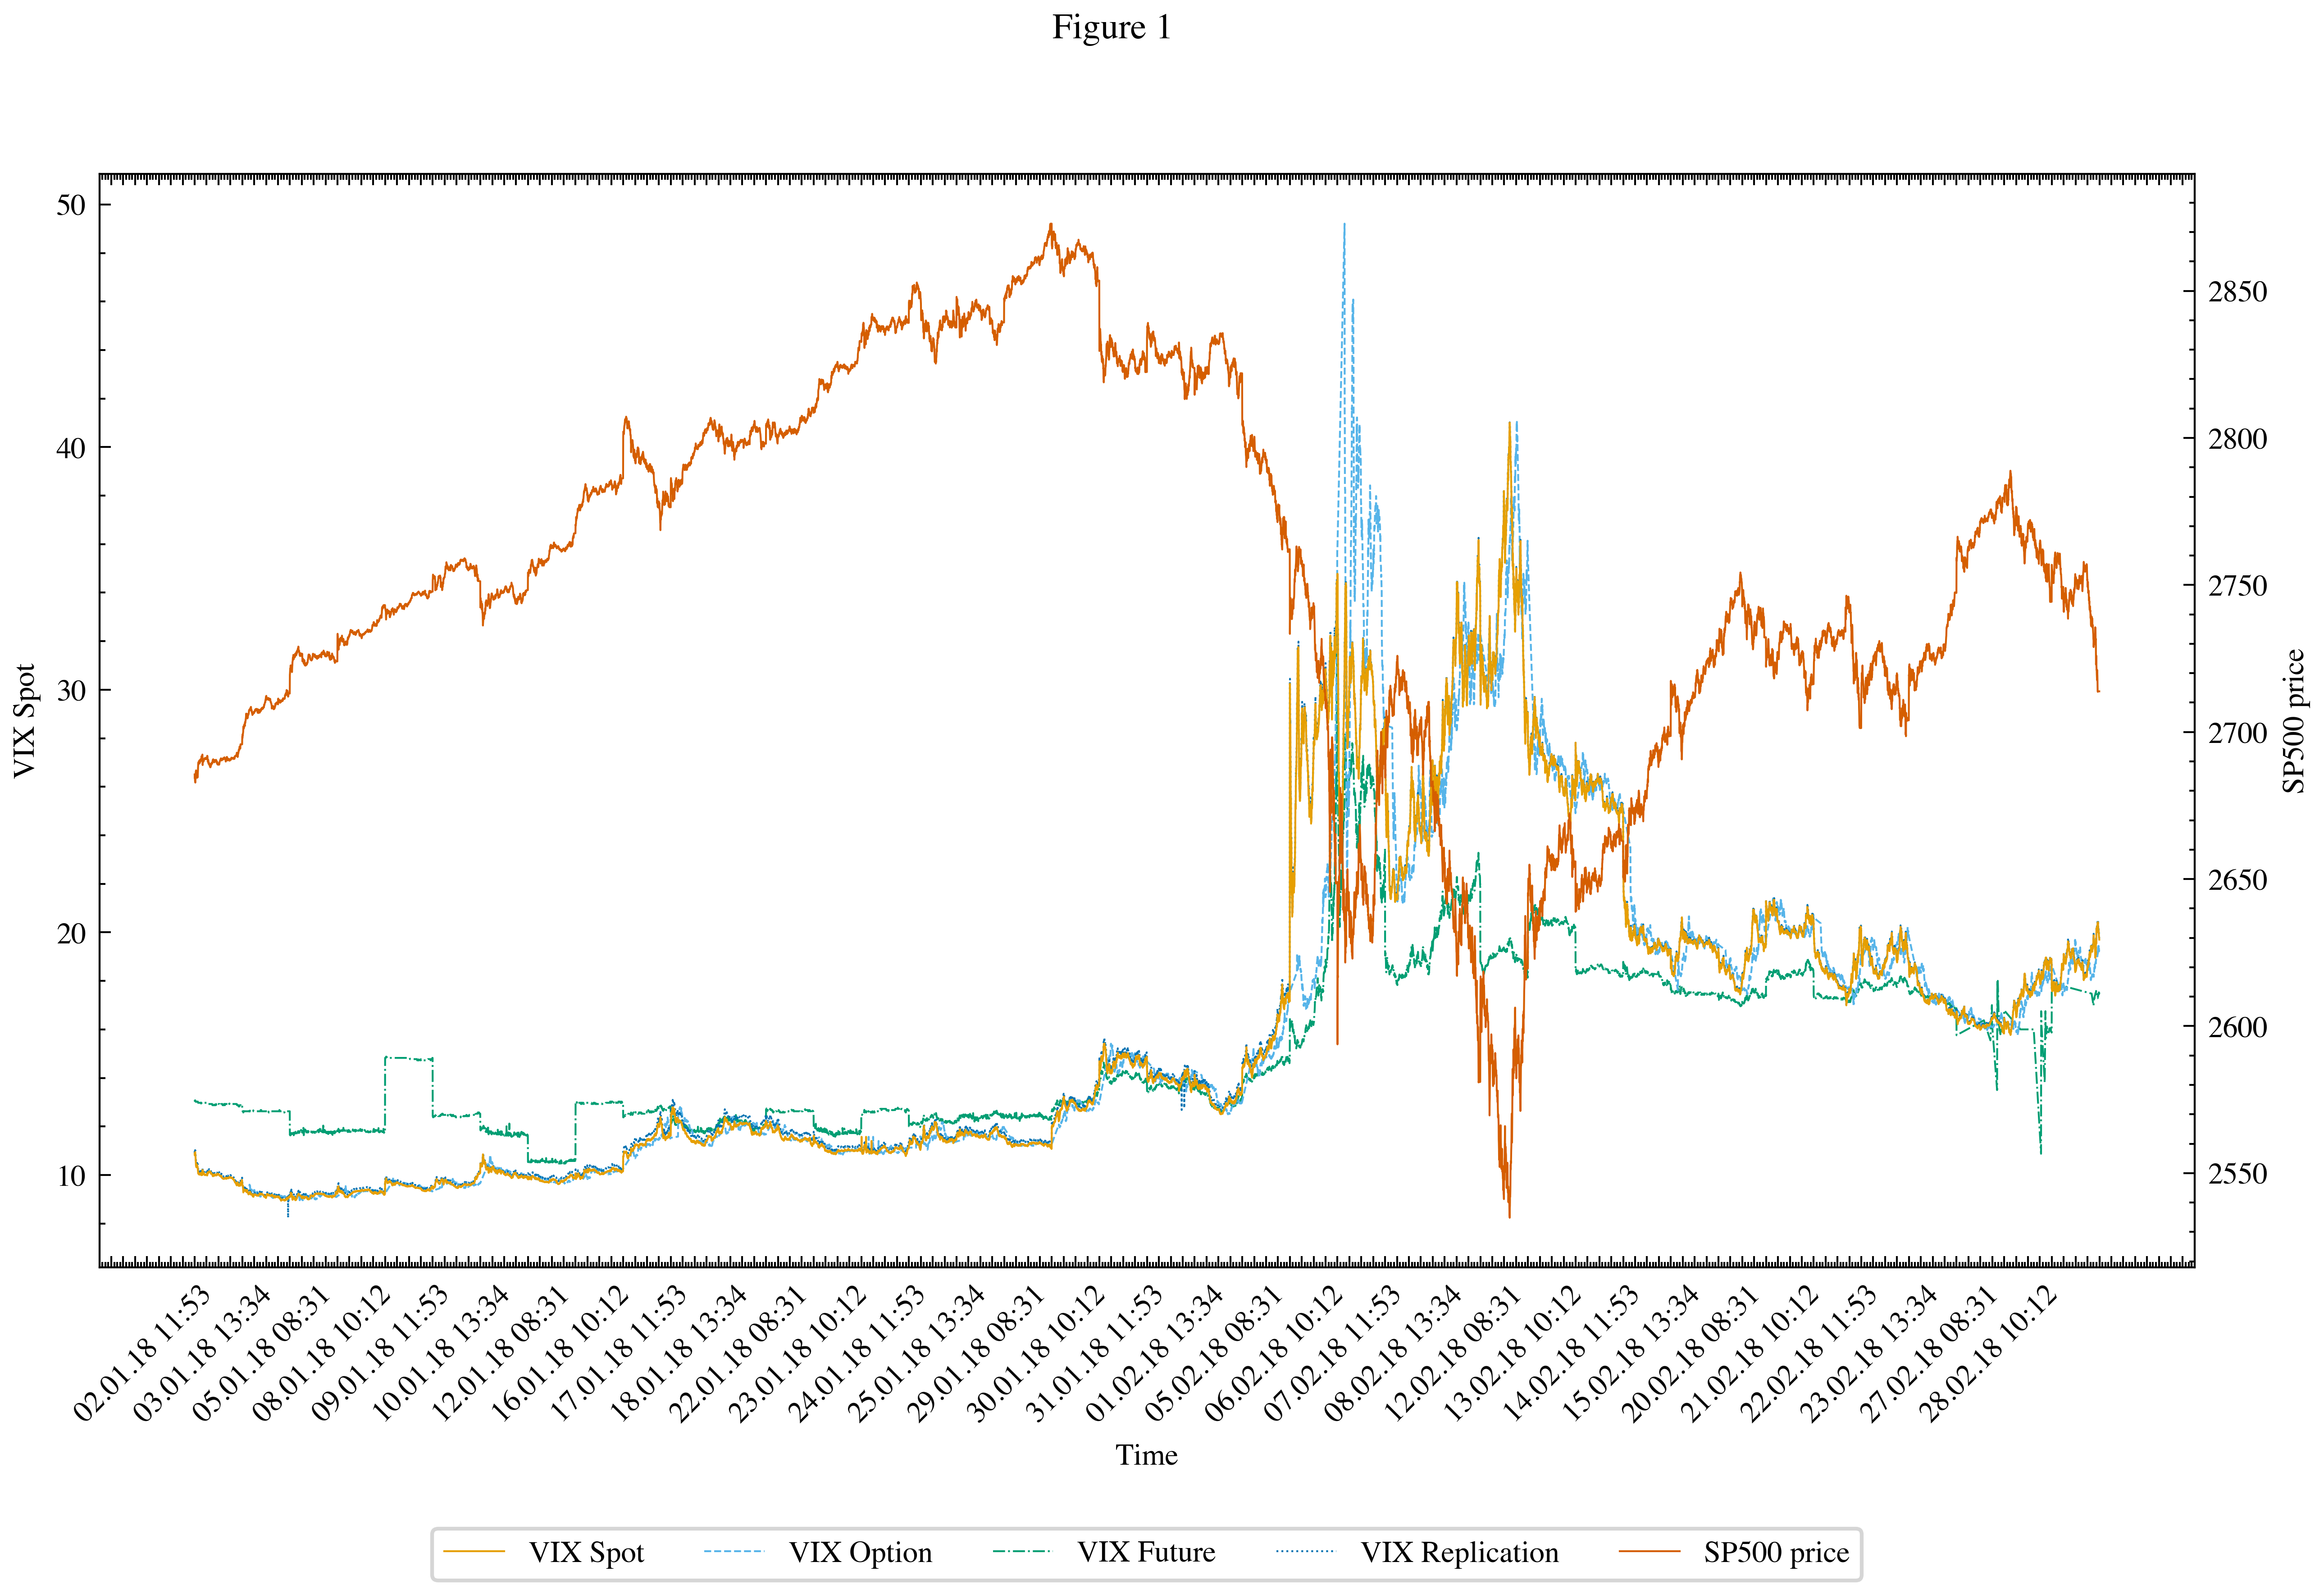

In [28]:
DrawDataFrame1(dfTotalFigure1)

In [83]:
#dfTotalFigure1.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/dfTotalFigure1.csv')

In [84]:
#sicherheit11 = dfTotalFigure1

In [141]:
dfTotalFigure1 = pd.read_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/dfTotalFigure1.csv')

In [142]:
dfTotalFigure1 = dfTotalFigure1.set_index('index')
#dfTotalFigure1.index =  pd.to_datetime(dfTotalFigure1.index)
#dfTotalFigure1['abs'] = abs(dfTotalFigure1['vix_spot'].dropna()-dfTotalFigure1['vix'].dropna())
dfTotalFigure1

vix_spot  SP500 price  VIX Option    vix  VIX FUTURE   abs  \
index                                                                        
02.01.18 08:31    10.880     2685.580         nan 10.912      13.075 0.032   
02.01.18 08:32    10.810     2684.300         nan 10.997      13.049 0.027   
02.01.18 08:33    10.840     2685.300         nan 10.933      13.056 0.047   
02.01.18 08:34    10.910     2683.730         nan 10.989      13.075 0.039   
02.01.18 08:35    10.920     2683.070         nan 11.020      13.075 0.050   
...                  ...          ...         ...    ...         ...   ...   
28.02.18 15:10    19.950     2713.830      19.960 17.582      17.526 0.034   
28.02.18 15:11    19.870     2713.830      19.880 17.563      17.512 0.038   
28.02.18 15:12    19.770     2713.830      19.800 17.488      17.512 0.038   
28.02.18 15:13    19.780     2713.830      19.810 17.508      17.462 0.038   
28.02.18 15:14    19.700     2713.830      19.700 17.390      17.512 0.038   

                sqrt  perct  
index                        
02.01.18 08:31 0.001  0.003  
02.01.18 08:32 0.001  0.002  
02.01.18 08:33 0.002  0.004  
02.01.18 08:34 0.002  0.004  
02.01.18 08:35 0.003  0.005  
...              ...    ...  
28.02.18 15:10 0.001  0.002  
28.02.18 15:11 0.001  0.002  
28.02.18 15:12 0.001  0.002  
28.02.18 15:13 0.001  0.002  
28.02.18 15:14 0.001  0.002  

[16160 rows x 8 columns]

In [143]:
dfTotalFigure1 = pd.DataFrame(dfTotalFigure1)
dfTotalFigure1['perct'] = pd.to_numeric(dfTotalFigure1['perct'].dropna())
dfTotalFigure1['perct'] = dfTotalFigure1['perct']*100
dfTotalFigure1


vix_spot  SP500 price  VIX Option    vix  VIX FUTURE   abs  \
index                                                                        
02.01.18 08:31    10.880     2685.580         nan 10.912      13.075 0.032   
02.01.18 08:32    10.810     2684.300         nan 10.997      13.049 0.027   
02.01.18 08:33    10.840     2685.300         nan 10.933      13.056 0.047   
02.01.18 08:34    10.910     2683.730         nan 10.989      13.075 0.039   
02.01.18 08:35    10.920     2683.070         nan 11.020      13.075 0.050   
...                  ...          ...         ...    ...         ...   ...   
28.02.18 15:10    19.950     2713.830      19.960 17.582      17.526 0.034   
28.02.18 15:11    19.870     2713.830      19.880 17.563      17.512 0.038   
28.02.18 15:12    19.770     2713.830      19.800 17.488      17.512 0.038   
28.02.18 15:13    19.780     2713.830      19.810 17.508      17.462 0.038   
28.02.18 15:14    19.700     2713.830      19.700 17.390      17.512 0.038   

                sqrt  perct  
index                        
02.01.18 08:31 0.001  0.295  
02.01.18 08:32 0.001  0.247  
02.01.18 08:33 0.002  0.431  
02.01.18 08:34 0.002  0.360  
02.01.18 08:35 0.003  0.460  
...              ...    ...  
28.02.18 15:10 0.001  0.170  
28.02.18 15:11 0.001  0.194  
28.02.18 15:12 0.001  0.192  
28.02.18 15:13 0.001  0.191  
28.02.18 15:14 0.001  0.195  

[16160 rows x 8 columns]

In [113]:
book1 = pd.read_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/book1.csv')
book1 = pd.DataFrame(book1)
book1['abs'].plot

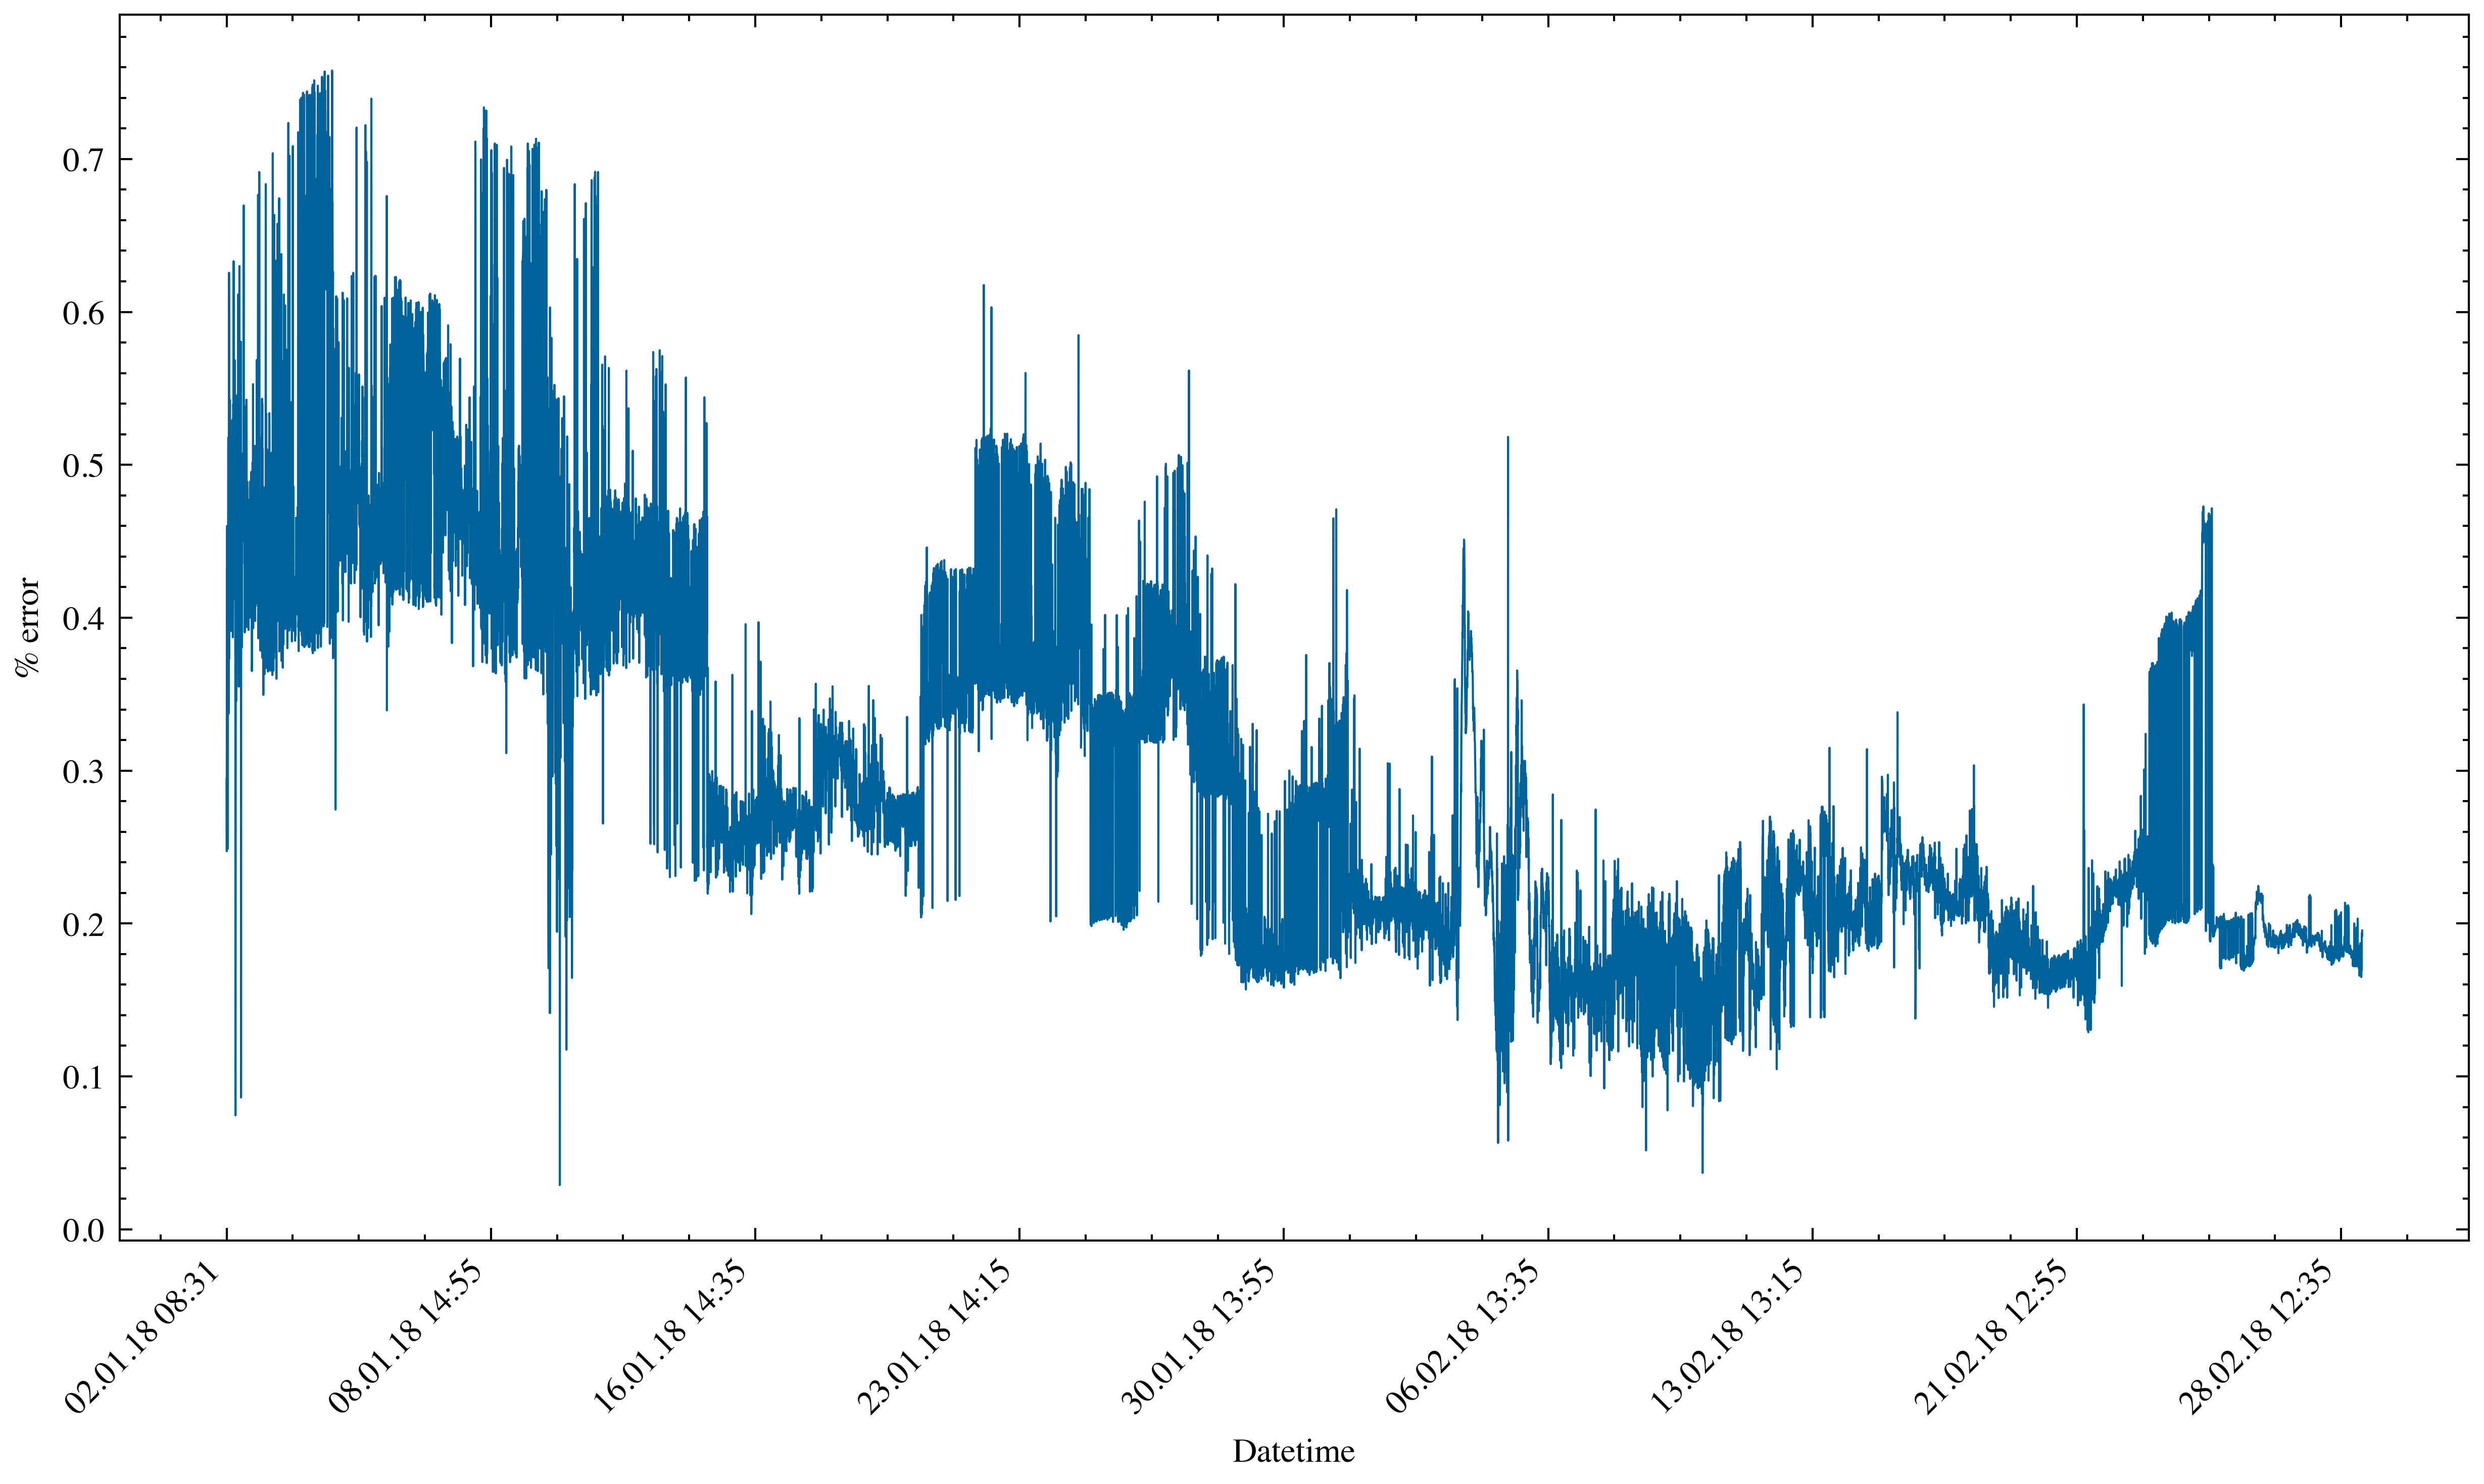

In [145]:
plt.style.use(['science','ieee', 'no-latex'])
#compare VIX Spot with Replicated VIX

#df = df.iloc[df.index % 15 == 0,]   # get one from four values
length = 10
height = length/1.681
fig=plt.figure(figsize=(length, height))

ax1 = dfTotalFigure1['perct'].dropna().plot(linestyle='-', color= '#00629B',linewidth=0.5, zorder=5)
ax1.set_xlabel('Datetime')
ax1.set_ylabel('% error')


fig.autofmt_xdate(rotation=45)
n = 1  # Keeps every 7th label
[l.set_visible(False) for (i,l) in enumerate(ax1.xaxis.get_ticklabels()) if i % n != 0]

plt.show()


In [ ]:
plt.style.use(['science','ieee', 'no-latex'])
#compare VIX Spot with Replicated VIX

#df = df.iloc[df.index % 15 == 0,]   # get one from four values
length = 4
height = length/1.681
fig=plt.figure(figsize=(length, height))

ax1 = dfTotalFigure1['abs'].dropna().plot(linestyle='-', color= '#00629B',linewidth=0.5, zorder=5)
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Absolut error')


fig.autofmt_xdate(rotation=45)
n = 1  # Keeps every 7th label
[l.set_visible(False) for (i,l) in enumerate(ax1.xaxis.get_ticklabels()) if i % n != 0]

plt.show()

#### Produce one time series plot (Figure 2) (y-axis Implied Volatility 0 - 1, x-axis date) from 1. Jan until 28. Feb with

In [156]:
IV_VIXA = ImpliedVolVIXA
IV_VIXA = IV_VIXA.rename(columns={'implied_volatility':'IV VIX'})
IV_SPXA = ImpliedVolSPXA
IV_SPXA = IV_SPXA.rename(columns={'implied_volatility':'IV SPX'})
dfTotalDraw2A = pd.concat([IV_VIXA['IV VIX'], IV_SPXA['IV SPX']], axis=1)
#DrawDataFrame2(dfTotalDraw2A)
dfTotalDraw2A

IV VIX  IV SPX
quote_datetime                     
2018-01-02 08:31:00     nan   0.080
2018-01-02 08:32:00     nan   0.082
2018-01-02 08:33:00     nan   0.080
2018-01-02 08:34:00     nan   0.081
2018-01-02 08:35:00     nan   0.082
...                     ...     ...
2018-02-28 15:10:00   1.681   0.150
2018-02-28 15:11:00   1.681   0.150
2018-02-28 15:12:00   1.743   0.150
2018-02-28 15:13:00   1.743   0.150
2018-02-28 15:14:00   1.718   0.149

[15756 rows x 2 columns]

In [157]:
IV_VIXB = ImpliedVolVIXB
IV_VIXB = IV_VIXB.rename(columns={'implied_volatility':'IV VIX'})
IV_SPXB = ImpliedVolSPXB
IV_SPXB = IV_SPXB.rename(columns={'implied_volatility':'IV SPX'})
dfTotalDraw2B = pd.concat([IV_VIXB['IV VIX'], IV_SPXB['IV SPX']], axis=1)
dfTotalDraw2B = dfTotalDraw2B.rename_axis('DATETIME').reset_index()
dfTotalDraw2B['DATETIME'] = dfTotalDraw2B['DATETIME'].astype(str)
dfTotalDraw2B = dfTotalDraw2B.set_index('DATETIME')
#dfTotalDraw2B['DATETIME'] = pd.to_datetime(dfTotalDraw2B['DATETIME'])
#DrawDataFrame2(dfTotalDraw2B)

In [158]:
dfTotalFigure2 = pd.concat([dfTotalDraw2A, dfTotalDraw2B])
dfTotalFigure2.index = pd.to_datetime(dfTotalFigure2.index)
dfTotalFigure2 = dfTotalFigure2.sort_index()
dfTotalFigure2 = dfTotalFigure2.reset_index()
dfTotalFigure2

index  IV VIX  IV SPX
0     2018-01-02 08:31:00     nan   0.080
1     2018-01-02 08:32:00     nan   0.082
2     2018-01-02 08:33:00     nan   0.080
3     2018-01-02 08:34:00     nan   0.081
4     2018-01-02 08:35:00     nan   0.082
...                   ...     ...     ...
16155 2018-02-28 15:10:00   1.681   0.150
16156 2018-02-28 15:11:00   1.681   0.150
16157 2018-02-28 15:12:00   1.743   0.150
16158 2018-02-28 15:13:00   1.743   0.150
16159 2018-02-28 15:14:00   1.718   0.149

[16160 rows x 3 columns]

In [162]:
def DrawDataFrame2(df):
    plt.style.use(['science','ieee', 'no-latex'])
    #compare VIX Spot with Replicated VIX
    length = 10
    height = length/1.681
    fig=plt.figure(figsize=(length, height))
    ax1 = df['IV VIX'].dropna().plot(label='IV VIX',linestyle='--', color='#E69F00', linewidth=0.5, zorder=2)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('IV VIX')
    ax2 = df['IV SPX'].dropna().plot(secondary_y=True, label='IV SPX', linestyle='-.', color='#56B4E9',  linewidth=0.5, zorder=3)
    ax2.set_ylabel('IV SPX')
    
    handles,labels = [],[]
    for ax in fig.axes:
        for h,l in zip(*ax.get_legend_handles_labels()):
            handles.append(h)
            labels.append(l)
    
    plt.xticks(df.index, df['index'])
    ax.xaxis.set_major_locator(MultipleLocator(101))
    plt.legend(handles,labels,loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=len(df.columns), frameon=True)
    plt.savefig('Figures/figure2.png')
    fig.autofmt_xdate(rotation=45)
    ax.spines['bottom'].set_position(('axes', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    n = 5  # Keeps every 7th label
    [l.set_visible(False) for (i,l) in enumerate(ax1.xaxis.get_ticklabels()) if i % n != 0]
    plt.show()

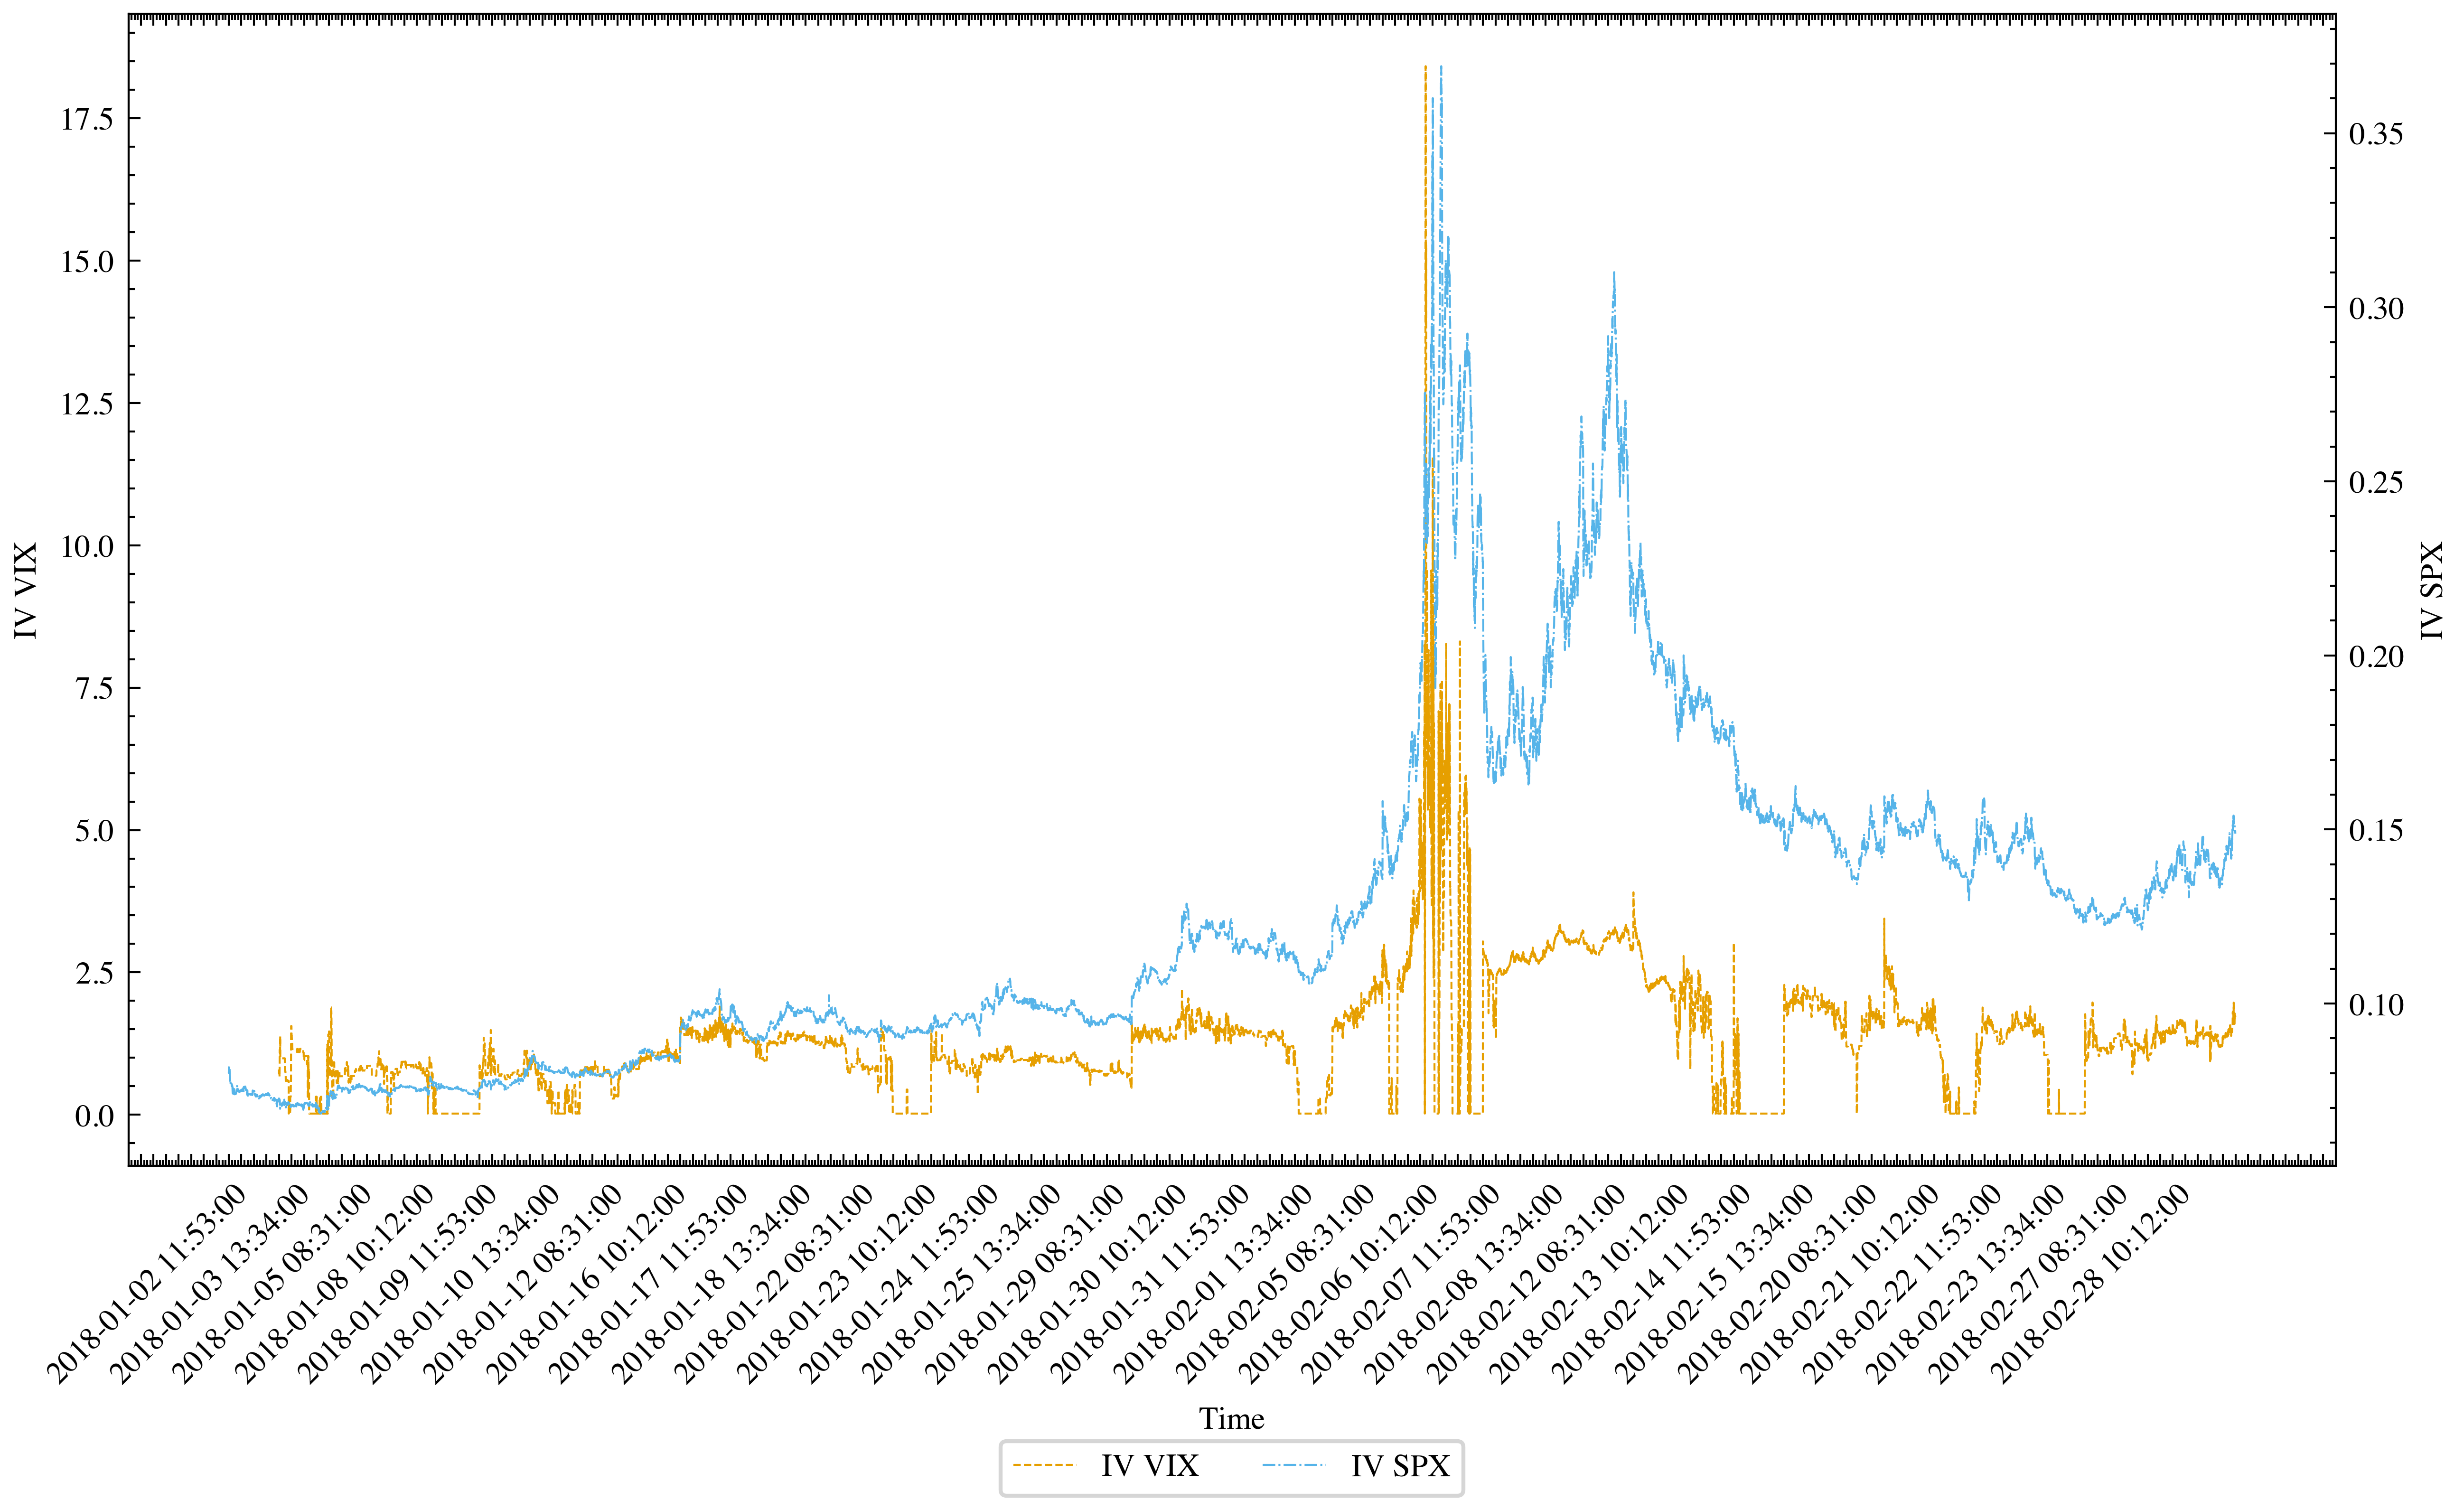

In [163]:
DrawDataFrame2(dfTotalFigure2)

#### Produce one time series plot (Figure 3) (y-axis Trading Volume, x-axis date) from 1. Jan until 28. Feb for all six calculated Trading Volumes

In [122]:
def DrawDataFrame3(df, title,  prefix):
    plt.style.use(['science','ieee', 'no-latex'])
    #compare VIX Spot with Replicated VIX
    fig=plt.figure(figsize=(12, 5))
    fig.suptitle(title)
    from matplotlib.dates import DateFormatter
    ax1 = df['ITM Trading Volume'].dropna().plot(label='ITM Trading Volume',linestyle='-', color='#e35a24', linewidth=0.5, zorder=2)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('VIX Spot')
    ax2 = df['OTM Trading Volume'].dropna().plot(label='OTM Trading Volume', linestyle='-', color='#19ef60', linewidth=0.5, zorder=2)
    ax3 = df['ATM Trading Volume'].dropna().plot(label='ATM Trading Volume', linestyle='-', color='#092f60', linewidth=0.5, zorder=2)
    ax3.set_ylabel(prefix + 'Trading Volume')
    
    handles,labels = [],[]
    for ax in fig.axes:
        for h,l in zip(*ax.get_legend_handles_labels()):
            handles.append(h)
            labels.append(l)
    #print(dir(ax.spines))
    
    plt.xticks(df.index, df['DATETIME'])
    ax.xaxis.set_major_locator(MultipleLocator(101))
    
    ax.spines['right'].set_position(('axes', 1))
    plt.legend(handles,labels,loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=len(df.columns), frameon=True)
    plt.savefig('Figures/figure1.png')
    fig.autofmt_xdate(rotation=45)

    plt.show()

In [123]:
SPXTradingVolume = pd.concat([SPXTradingVolumeA, SPXTradingVolumeB])
SPXTradingVolume.index = pd.to_datetime(SPXTradingVolume.index)
SPXTradingVolume = SPXTradingVolume.sort_index()
SPXTradingVolume = SPXTradingVolume.reset_index()
SPXTradingVolume

NameError: name 'SPXTradingVolumeA' is not defined

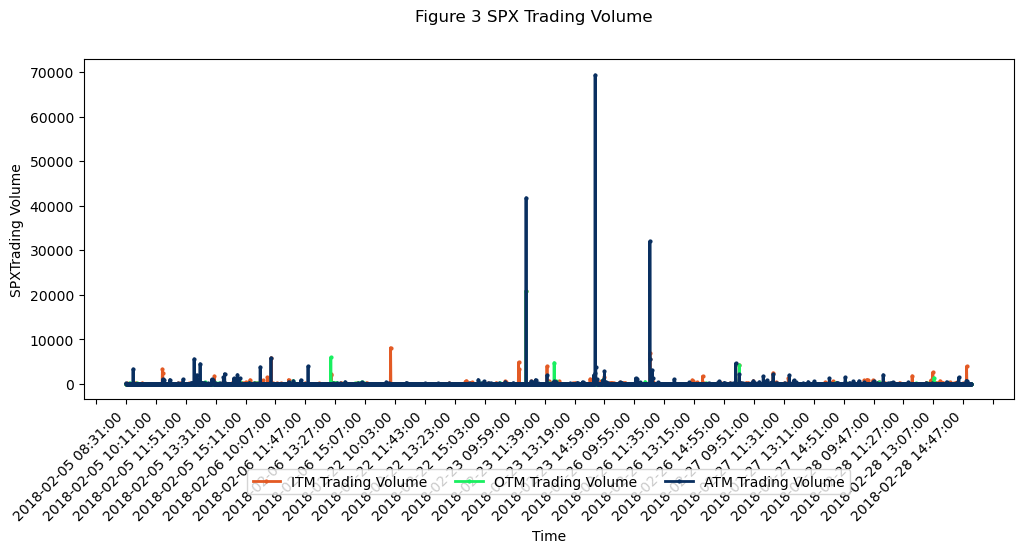

In [ ]:
DrawDataFrame3(SPXTradingVolume, 'Figure 3 SPX Trading Volume', 'SPX')

In [ ]:
VixTradingVolume = pd.concat([VixTradingVolumeA, VixTradingVolumeB])
VixTradingVolume.index = pd.to_datetime(VixTradingVolume.index)
VixTradingVolume = VixTradingVolume.sort_index()
VixTradingVolume = VixTradingVolume.reset_index()
VixTradingVolume

DATETIME  ITM Trading Volume  OTM Trading Volume  \
0    2018-02-05 08:31:00                1177                   2   
1    2018-02-05 08:32:00                 131                   1   
2    2018-02-05 08:33:00                 314                 152   
3    2018-02-05 08:34:00                  97                   7   
4    2018-02-05 08:35:00                 264                   8   
...                  ...                 ...                 ...   
3227 2018-02-28 15:10:00                   0                   0   
3228 2018-02-28 15:11:00                   0                   0   
3229 2018-02-28 15:12:00                   0                   0   
3230 2018-02-28 15:13:00                   0                   0   
3231 2018-02-28 15:14:00                  20                   0   

      ATM Trading Volume  
0                  0.000  
1                 18.000  
2                  0.000  
3                  0.000  
4                  0.000  
...                  ...  
3227               0.000  
3228               0.000  
3229               0.000  
3230               0.000  
3231               0.000  

[3232 rows x 4 columns]

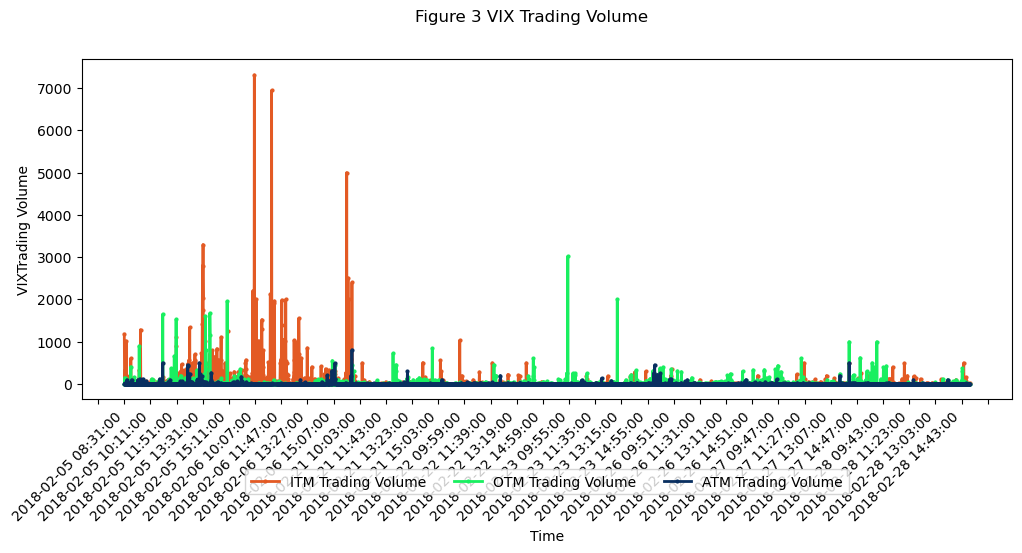

In [ ]:
DrawDataFrame3(VixTradingVolume, 'Figure 3 VIX Trading Volume', 'VIX')

In [44]:
#VixFuturePerMinB = VixFuturePerMinB.drop(index=pd.to_datetime('2018-02-05 08:30:00'))

#### Produce one table (Table 1) with summary statistics of Levels and Returns which contains the same information like on page 31 Shu and Zhang “Table 1”

In [176]:
dfTotalTableA = pd.concat([SPXOptionPerMinA['SP500 price'], VixSpotPerMinA['vix_spot'], VixFuturePerMinA['VIX FUTURE'], IV_VIXA['IV VIX'], IV_SPXA['IV SPX']], axis=1)
dfTotalTableA = dfTotalTableA.rename(columns={'vix':'Replication VIX'})

dfTotalTableB = pd.concat([SPXOptionPerMinB['SP500 price'], VixSpotPerMinB['vix_spot'], VixFuturePerMinB['VIX FUTURE'], IV_VIXB['IV VIX'], IV_SPXB['IV SPX']], axis=1)
dfTotalTableB = dfTotalTableB.rename(columns={'vix':'Replication VIX'})

listColumns = ['SP500 price', 'vix_spot', 'VIX FUTURE', 'IV VIX', 'IV SPX']

## Kurt[X] = E $ \left[ (\frac{X - \mu}{\sigma})^4\right] = \frac{E[(X-\mu)^4]}{(E[(X-\mu)^2])^2} = \frac{\mu_4}{\sigma^4}$

## Skewness[X] = E $ \left[ (\frac{X - \mu}{\sigma})^3\right] = \frac{\mu_3}{\sigma^3}$

In [177]:
def GetOffSets(df):
    dfTem = df
    meanList = []
    medianList = []
    sigmaList = []
    SkewnessList = []
    KurtosisList = []
    RangeList =[]
    MaxList = []
    MinList = []
    
    index = math.floor((len(df) - 1) / 2)
    nLen = len(dfTem)

    for field in listColumns:
        meanList.append(dfTem[field].mean())

        medianList.append(dfTem[field][index])

        dfTem['sig'] = (dfTem[field] - dfTem[field].mean())
        dfTem['tem'] =  dfTem['sig']
        dfTem['tem'] = dfTem['tem'] * dfTem['sig']
        sigma = np.sqrt(dfTem['tem'].sum() / nLen)
        sigmaList.append(sigma)

        dfTem['tem'] = dfTem['tem'] * dfTem['sig']
        SkewnessList.append((dfTem['tem'].sum() / nLen) / (sigma * sigma * sigma))

        dfTem['tem'] = dfTem['tem'] * dfTem['sig']
        KurtosisList.append((dfTem['tem'].sum() / nLen) / (sigma * sigma * sigma * sigma))
        
        MaxList.append(dfTem[field].max())
        MinList.append(dfTem[field].min())
        RangeList.append(dfTem[field].max() - dfTem[field].min())
    dfTem = dfTem.drop(columns=['tem', 'sig'])
    return [meanList, medianList, sigmaList, SkewnessList, KurtosisList, RangeList, MaxList, MinList]

In [178]:
[meanListA, medianListA, sigmaListA, SkewnessListA, KurtosisListA, RangeListA, MaxListA, MinListA] = GetOffSets(dfTotalTableA)
[meanListB, medianListB, sigmaListB, SkewnessListB, KurtosisListB, RangeListB, MaxListB, MinListB] = GetOffSets(dfTotalTableB)

In [179]:
dfTable1_A = pd.DataFrame([meanListA, medianListA, sigmaListA, SkewnessListA, KurtosisListA, RangeListA, MaxListA, MinListA])
dfTable1_A.columns = listColumns
dfTable1_A.index = ['mean', 'median', 'sd', 'Skewness', 'Kurtosis', 'Range', 'Max', 'Min']

In [180]:
dfTable1_B = pd.DataFrame([meanListB, medianListB, sigmaListB, SkewnessListB, KurtosisListB, RangeListB, MaxListB, MinListB])
dfTable1_B.columns = listColumns
dfTable1_B.index = ['mean', 'median', 'sd', 'Skewness', 'Kurtosis', 'Range', 'Max', 'Min']

In [181]:
def GetReturnDF(df):
    ret = df
    ret = ret.sort_index(ascending=True)
    ret = ret.rename_axis('DATETIME').reset_index()
    dfstamp = ret['DATETIME'].astype(str)
    for i in range(0 , len(dfstamp)):
        strtemp = dfstamp.iloc[i]
        dfstamp.iloc[i] = strtemp[:(len(strtemp)-5)] + '00:00'
    ret['DATETIME'] = dfstamp
    
    dateUnique = ret['DATETIME'].unique()
    dfStart = pd.DataFrame()
    dfClose = pd.DataFrame()
    for i in dateUnique:
        dfTem = ret[ret['DATETIME']==i]
        ddT1 = pd.DataFrame([dfTem.iloc[0]])
        dfStart = pd.concat([dfStart, ddT1])
        dfTem = dfTem.sort_index(ascending=False)
        ddT2 = pd.DataFrame([dfTem.iloc[0]])
        dfClose = pd.concat([dfClose, ddT2])
          
    dfStart = dfStart.rename(columns={'SP500 price':'SP500 price start', 'vix_spot':'vix_spot start', 'VIX FUTURE':'VIX FUTURE start',  'IV VIX':'IV VIX start', 'IV SPX':'IV SPX start'})
    dfClose = dfClose.rename(columns={'SP500 price':'SP500 price close', 'vix_spot':'vix_spot close', 'VIX FUTURE':'VIX FUTURE close', 'IV VIX':'IV VIX close', 'IV SPX':'IV SPX close'})
    
    ret = pd.merge(dfStart, dfClose, on='DATETIME', how='left')
    
    ret['SP500 price start'] = ret['SP500 price start'] / ret['SP500 price close'] - 1
    ret['vix_spot start'] = ret['vix_spot start'] / ret['vix_spot close'] - 1
    ret['VIX FUTURE start'] = ret['VIX FUTURE start'] / ret['VIX FUTURE close'] - 1
    
    ret['IV VIX start'] = ret['IV VIX start'] / ret['IV VIX close'] - 1
    ret['IV SPX start'] = ret['IV SPX start'] / ret['IV SPX close'] - 1
    
    ret = ret.rename(columns={'SP500 price start':'SP500 price', 'vix_spot start':'vix_spot', 'VIX FUTURE start':'VIX FUTURE', 'IV VIX start':'IV VIX', 'IV SPX start':'IV SPX'})
    #print(ret)
    ret = ret.drop(columns=['SP500 price close', 'vix_spot close', 'VIX FUTURE close', 'IV VIX close', 'IV SPX close'])
    ret = ret.set_index('DATETIME')
    return ret

In [182]:
returnTotalTableA = GetReturnDF(dfTotalTableA)
returnTotalTableB = GetReturnDF(dfTotalTableB)

In [183]:
[return_meanListA, return_medianListA, return_sigmaListA, return_SkewnessListA, return_KurtosisListA, return_RangeListA, return_MaxListA, return_MinListA] = GetOffSets(returnTotalTableA)
[return_meanListB, return_medianListB, return_sigmaListB, return_SkewnessListB, return_KurtosisListB, return_RangeListB, return_MaxListB, return_MinListB] = GetOffSets(returnTotalTableB)

In [184]:
return_dfTable1_A = pd.DataFrame([return_meanListA, return_medianListA, return_sigmaListA, return_SkewnessListA, return_KurtosisListA, return_RangeListA, return_MaxListA, return_MinListA])
return_dfTable1_A.columns = ['SP500', 'vix_spot', 'VIX FUTURE',  'IV VIX', 'IV SPX']
return_dfTable1_A.index = ['mean', 'median', 'sd', 'Skewness', 'Kurtosis', 'Range', 'Max', 'Min']

In [185]:
return_dfTable1_B = pd.DataFrame([return_meanListB, return_medianListB, return_sigmaListB, return_SkewnessListB, return_KurtosisListB, return_RangeListB, return_MaxListB, return_MinListB])
return_dfTable1_B.columns = listColumns
return_dfTable1_B.index = ['mean', 'median', 'sd', 'Skewness', 'Kurtosis', 'Range', 'Max', 'Min']

In [186]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle(['']), TotalTitle=cycle('')):
    html_str = ''
    html_str+=f'<div><h2>{TotalTitle}</h2></div>'
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<div><th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h6>{title}</h6>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th></div>'
    display_html(html_str,raw=True)


In [190]:
display_side_by_side(dfTable1_A, return_dfTable1_A, titles=['Summary statistics of levels','Summary statistics of returns'], TotalTitle = 'Table 1')
dfTable1_A.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/tabellen/dfTable1_A.csv')
return_dfTable1_A.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/tabellen/return_dfTable1_A.csv')


Table 1 Summary statistics of levels 
 
 
 
 SP500 price 
 vix_spot 
 VIX FUTURE 
 IV VIX 
 IV SPX 
 
 
 
 
 mean 
 2753.004 
 15.760 
 15.033 
 1.222 
 0.125 
 
 
 median 
 2823.450 
 14.980 
 14.249 
 1.690 
 0.123 
 
 
 sd 
 66.059 
 6.453 
 3.295 
 0.873 
 0.048 
 
 
 Skewness 
 -0.407 
 1.160 
 0.954 
 1.722 
 1.407 
 
 
 Kurtosis 
 2.821 
 3.685 
 3.562 
 11.846 
 5.098 
 
 
 Range 
 338.050 
 32.070 
 17.724 
 11.529 
 0.301 
 
 
 Max 
 2872.870 
 41.010 
 28.199 
 11.549 
 0.369 
 
 
 Min 
 2534.820 
 8.940 
 10.475 
 0.020 
 0.068 
 
 
 Summary statistics of returns 
 
 
 
 SP500 
 vix_spot 
 VIX FUTURE 
 IV VIX 
 IV SPX 
 
 
 
 
 mean 
 -0.000 
 0.002 
 0.001 
 4.417 
 0.004 
 
 
 median 
 0.001 
 0.000 
 -0.007 
 0.116 
 -0.007 
 
 
 sd 
 0.003 
 0.041 
 0.024 
 37.028 
 0.053 
 
 
 Skewness 
 -0.953 
 2.796 
 2.701 
 13.270 
 4.917 
 
 
 Kurtosis 
 15.364 
 30.116 
 34.275 
 193.313 
 58.319 
 
 
 Range 
 0.038 
 0.554 
 0.345 
 577.455 
 0.798 
 
 
 Max 
 0.014 
 0.390 
 0.223 
 576.460 
 0.605 
 
 
 Min 
 -0.023 
 -0.164 
 -0.122 
 -0.995 
 -0.193

In [189]:
display_side_by_side(dfTable1_B, return_dfTable1_B, titles=['Summary statistics of levels','Summary statistics of returns'], TotalTitle = 'Table 1')
dfTable1_B.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/tabellen/dfTable1_B.csv')
return_dfTable1_B.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/tabellen/return_dfTable1_B.csv')

Table 1 Summary statistics of levels 
 
 
 
 SP500 price 
 vix_spot 
 VIX FUTURE 
 IV VIX 
 IV SPX 
 
 
 
 
 mean 
 2725.600 
 28.169 
 17.775 
 3.169 
 0.177 
 
 
 median 
 2743.110 
 27.140 
 16.248 
 2.649 
 0.153 
 
 
 sd 
 30.804 
 2.771 
 2.906 
 2.486 
 0.043 
 
 
 Skewness 
 -1.022 
 -0.617 
 2.158 
 2.401 
 1.387 
 
 
 Kurtosis 
 3.135 
 3.150 
 8.842 
 13.651 
 3.915 
 
 
 Range 
 117.510 
 13.820 
 17.277 
 18.396 
 0.208 
 
 
 Max 
 2763.130 
 34.465 
 32.493 
 18.416 
 0.344 
 
 
 Min 
 2645.620 
 20.645 
 15.216 
 0.020 
 0.136 
 
 
 Summary statistics of returns 
 
 
 
 SP500 price 
 vix_spot 
 VIX FUTURE 
 IV VIX 
 IV SPX 
 
 
 
 
 mean 
 0.003 
 -0.009 
 -0.065 
 16.330 
 -0.074 
 
 
 median 
 0.004 
 -0.023 
 -0.045 
 -0.136 
 -0.065 
 
 
 sd 
 0.006 
 0.141 
 0.084 
 43.890 
 0.106 
 
 
 Skewness 
 0.319 
 1.890 
 -0.452 
 2.268 
 -0.200 
 
 
 Kurtosis 
 2.061 
 5.255 
 2.135 
 6.142 
 2.000 
 
 
 Range 
 0.020 
 0.489 
 0.262 
 133.441 
 0.322 
 
 
 Max 
 0.014 
 0.348 
 0.041 
 132.450 
 0.076 
 
 
 Min 
 -0.006 
 -0.141 
 -0.221 
 -0.991 
 -0.245

#### Produce one time series plot (Figure 4) with rolling correlations from 1Jan until 28Feb like on Page 31 Shu and Zhang “Figure 2”

##### Pearson Correlation coefficient
## $\gamma_{XY} = \frac{ \frac {\sum_{i}^{n}(X_i-\overline X)(Y_i - \overline Y)}{n-1} }{\sqrt{ \frac{\sum_{i}{n}(X_i - \overline X)^2}{n-1}}\sqrt{\frac{\sum_{i}{n}(Y_i - \overline Y)^2}{n-1}}}$
##### Therefore,
## $\gamma_{XY} = \frac{ \sum_{i}^{n}(X_i-\overline X)(Y_i - \overline Y)}
{\sqrt{ \sum_{i}{n}(X_i - \overline X)^2}{\sqrt{\sum_{i}{n}(Y_i - \overline Y)^2}}}$

In [191]:
def GetDataOnlyDate(df):
    ret = df
    ret = ret.sort_index(ascending=True)
    ret = ret.rename_axis('DATETIME').reset_index()
    #ret['DATETIME_back'] = ret['DATETIME']
    dfstamp = ret['DATETIME'].astype(str)
    for i in range(0 , len(dfstamp)):
        strtemp = dfstamp.iloc[i]
        dfstamp.iloc[i] = strtemp[:(len(strtemp)-8)] + '00::00:00'
    ret['DATETIME'] = dfstamp
    return ret

In [192]:
def GetCorrelationForDate(df):
    dfTem = df
    dfTem['sig1'] = (dfTem['value1'] - dfTem['value1'].mean())
    dfTem['sig2'] = (dfTem['value2'] - dfTem['value2'].mean())
    dfTem['up'] = dfTem['sig1'] * dfTem['sig2']
    upValue = dfTem['up'].sum()
    dfTem['down1'] =  dfTem['sig1'] * dfTem['sig1']
    dfTem['down2'] =  dfTem['sig2'] * dfTem['sig2']
    downValue = np.sqrt(dfTem['down1'].sum()) * np.sqrt(dfTem['down2'].sum())
    
    ret = upValue / downValue;
    
    return ret

In [193]:
def GetCorrelations(df):
    dfT = df
    
    dfTem = GetDataOnlyDate(dfT)
    #print(dfTem)
    dateUnique = dfTem['DATETIME'].unique()
    ret = pd.DataFrame()
    
    #print(dateUnique)
    indexList = []
    for i in dateUnique:
        #print(i)
        dfDate = dfTem[dfTem['DATETIME']==i]
        correlationValue = GetCorrelationForDate(dfDate)
        dfTTT = pd.DataFrame([correlationValue])
        ret = pd.concat([ret, dfTTT])
        indexList.append(i)
    ret.index = indexList
    
    return ret

In [194]:
dfTotalTableAB = pd.concat([dfTotalTableA, dfTotalTableB])
dfTotalTableAB

SP500 price  vix_spot  VIX FUTURE  IV VIX  IV SPX    sig  \
2018-01-02 08:31:00     2685.580    10.880      13.075     nan   0.080 -0.045   
2018-01-02 08:32:00     2684.300    10.810      13.049     nan   0.082 -0.043   
2018-01-02 08:33:00     2685.300    10.840      13.056     nan   0.080 -0.045   
2018-01-02 08:34:00     2683.730    10.910      13.075     nan   0.081 -0.043   
2018-01-02 08:35:00     2683.070    10.920      13.075     nan   0.082 -0.043   
...                          ...       ...         ...     ...     ...    ...   
2018-02-05 15:10:00     2648.940    34.325      32.493     nan   0.296  0.119   
2018-02-05 15:11:00     2648.940    33.540      31.837   5.612   0.308  0.130   
2018-02-05 15:12:00     2648.940    33.545      29.991   5.303   0.344  0.167   
2018-02-05 15:13:00     2648.940    33.505      30.993   4.329   0.300  0.123   
2018-02-05 15:14:00     2648.940    33.650      30.922   5.388   0.309  0.131   

                      tem  
2018-01-02 08:31:00 0.000  
2018-01-02 08:32:00 0.000  
2018-01-02 08:33:00 0.000  
2018-01-02 08:34:00 0.000  
2018-01-02 08:35:00 0.000  
...                   ...  
2018-02-05 15:10:00 0.000  
2018-02-05 15:11:00 0.000  
2018-02-05 15:12:00 0.001  
2018-02-05 15:13:00 0.000  
2018-02-05 15:14:00 0.000  

[16160 rows x 7 columns]

In [195]:
SPX_VIX_correlation = pd.concat([dfTotalTableAB['SP500 price'], dfTotalTableAB['vix_spot']], axis=1)
SPX_VIX_correlation = SPX_VIX_correlation.rename(columns={'SP500 price':'value1', 'vix_spot':'value2'})
SPX_VIX_correlation = GetCorrelations(SPX_VIX_correlation)
SPX_VIX_correlation.columns = ['SPX_VIX']

In [196]:
SPX_FUTURE_correlation = pd.concat([dfTotalTableAB['SP500 price'], dfTotalTableAB['VIX FUTURE']], axis=1)
SPX_FUTURE_correlation = SPX_FUTURE_correlation.rename(columns={'SP500 price':'value1', 'VIX FUTURE':'value2'})
SPX_FUTURE_correlation = GetCorrelations(SPX_FUTURE_correlation)
SPX_FUTURE_correlation.columns = ['SPX_FUTURE']

In [197]:
SPX_IVSPX_correlation = pd.concat([dfTotalTableAB['SP500 price'], dfTotalTableAB['IV SPX']], axis=1)
SPX_IVSPX_correlation = SPX_IVSPX_correlation.rename(columns={'SP500 price':'value1', 'IV SPX':'value2'})
SPX_IVSPX_correlation = GetCorrelations(SPX_IVSPX_correlation)
SPX_IVSPX_correlation.columns = ['SPX_IV SPX']

In [198]:
SPX_IVVIX_correlation = pd.concat([dfTotalTableAB['SP500 price'], dfTotalTableAB['IV VIX']], axis=1)
SPX_IVVIX_correlation = SPX_IVVIX_correlation.rename(columns={'SP500 price':'value1', 'IV VIX':'value2'})
SPX_IVVIX_correlation = GetCorrelations(SPX_IVVIX_correlation)
SPX_IVVIX_correlation.columns = ['SPX_IV VIX']

In [199]:
SPOT_FUTURE_correlation = pd.concat([dfTotalTableAB['vix_spot'], dfTotalTableAB['VIX FUTURE']], axis=1)
SPOT_FUTURE_correlation = SPOT_FUTURE_correlation.rename(columns={'vix_spot':'value1', 'VIX FUTURE':'value2'})
SPOT_FUTURE_correlation = GetCorrelations(SPOT_FUTURE_correlation)
SPOT_FUTURE_correlation.columns = ['Vix Spot_Future']

In [200]:
SPOT_IVSPX_correlation = pd.concat([dfTotalTableAB['vix_spot'], dfTotalTableAB['IV SPX']], axis=1)
SPOT_IVSPX_correlation = SPOT_IVSPX_correlation.rename(columns={'vix_spot':'value1', 'IV SPX':'value2'})
SPOT_IVSPX_correlation = GetCorrelations(SPOT_IVSPX_correlation)
SPOT_IVSPX_correlation.columns = ['Vix Spot_IV SPX']

In [201]:
SPOT_IVVIX_correlation = pd.concat([dfTotalTableAB['vix_spot'], dfTotalTableAB['IV VIX']], axis=1)
SPOT_IVVIX_correlation = SPOT_IVVIX_correlation.rename(columns={'vix_spot':'value1', 'IV VIX':'value2'})
SPOT_IVVIX_correlation = GetCorrelations(SPOT_IVVIX_correlation)
SPOT_IVVIX_correlation.columns = ['Vix Spot_IV VIX']

In [202]:
CorrelationAB = pd.concat([SPX_VIX_correlation['SPX_VIX'], SPX_FUTURE_correlation['SPX_FUTURE'], SPX_IVSPX_correlation['SPX_IV SPX'], SPX_IVVIX_correlation['SPX_IV VIX'], SPOT_FUTURE_correlation['Vix Spot_Future'], SPOT_IVSPX_correlation['Vix Spot_IV SPX'], SPOT_IVVIX_correlation['Vix Spot_IV VIX']], axis=1)

In [203]:
CorrelationAB

SPX_VIX  SPX_FUTURE  SPX_IV SPX  SPX_IV VIX  \
2018-01-02 00::00:00   -0.869      -0.696      -0.861         nan   
2018-01-03 00::00:00   -0.841      -0.282      -0.503      -0.381   
2018-01-04 00::00:00    0.036       0.208       0.224      -0.374   
2018-01-05 00::00:00   -0.033      -0.465      -0.042       0.078   
2018-01-08 00::00:00   -0.872      -0.848      -0.821      -0.475   
...                       ...         ...         ...         ...   
2018-02-22 00::00:00   -0.876      -0.833      -0.884      -0.749   
2018-02-23 00::00:00   -0.885      -0.967      -0.910      -0.635   
2018-02-26 00::00:00   -0.622      -0.042      -0.144      -0.197   
2018-02-27 00::00:00   -0.972       0.373      -0.982      -0.770   
2018-02-28 00::00:00   -0.903       0.623      -0.935      -0.802   

                      Vix Spot_Future  Vix Spot_IV SPX  Vix Spot_IV VIX  
2018-01-02 00::00:00            0.759            0.955              nan  
2018-01-03 00::00:00            0.186            0.747            0.548  
2018-01-04 00::00:00            0.268            0.591            0.270  
2018-01-05 00::00:00            0.091            0.890            0.754  
2018-01-08 00::00:00            0.846            0.935            0.557  
...                               ...              ...              ...  
2018-02-22 00::00:00            0.944            0.980            0.885  
2018-02-23 00::00:00            0.908            0.990            0.886  
2018-02-26 00::00:00           -0.275            0.815            0.545  
2018-02-27 00::00:00           -0.447            0.988            0.826  
2018-02-28 00::00:00           -0.664            0.948            0.734  

[40 rows x 7 columns]

In [207]:
color1='#E69F00'
color2='#56B4E9'
color3='#009E73'
color4='#0072B2'
color5='#D55E00'
color6='#CC79A7'
color7='#F0E442'

In [292]:
CorrelationAB = lock

In [293]:
CorrelationAB = CorrelationAB.reset_index()

In [294]:
CorrelationAB['index'] = pd.to_datetime(CorrelationAB['index'], format='%Y-%m-%d %H::%M:%S') 
CorrelationAB = CorrelationAB.rename(columns = {'index':'Date'} )
CorrelationAB = CorrelationAB.set_index('Date')
#VixTradingVolume = VixTradingVolume.sort_index()
#VixTradingVolume = VixTradingVolume.reset_index()

CorrelationAB



SPX_VIX  SPX_FUTURE  SPX_IV SPX  SPX_IV VIX  Vix Spot_Future  \
Date                                                                       
2018-01-02   -0.869      -0.696      -0.861         nan            0.759   
2018-01-03   -0.841      -0.282      -0.503      -0.381            0.186   
2018-01-04    0.036       0.208       0.224      -0.374            0.268   
2018-01-05   -0.033      -0.465      -0.042       0.078            0.091   
2018-01-08   -0.872      -0.848      -0.821      -0.475            0.846   
...             ...         ...         ...         ...              ...   
2018-02-22   -0.876      -0.833      -0.884      -0.749            0.944   
2018-02-23   -0.885      -0.967      -0.910      -0.635            0.908   
2018-02-26   -0.622      -0.042      -0.144      -0.197           -0.275   
2018-02-27   -0.972       0.373      -0.982      -0.770           -0.447   
2018-02-28   -0.903       0.623      -0.935      -0.802           -0.664   

            Vix Spot_IV SPX  Vix Spot_IV VIX  
Date                                          
2018-01-02            0.955              nan  
2018-01-03            0.747            0.548  
2018-01-04            0.591            0.270  
2018-01-05            0.890            0.754  
2018-01-08            0.935            0.557  
...                     ...              ...  
2018-02-22            0.980            0.885  
2018-02-23            0.990            0.886  
2018-02-26            0.815            0.545  
2018-02-27            0.988            0.826  
2018-02-28            0.948            0.734  

[40 rows x 7 columns]

In [302]:
def DrawDataFrame4(df):
    #plt.style.use(['science','ieee', 'no-latex'])
    #compare VIX Spot with Replicated VIX
    length = 10
    height = length/1.681
    fig=plt.figure(figsize=(length, height))
    from matplotlib.dates import DateFormatter
    ax1 = df['SPX_VIX'].dropna().plot(label='S&P 500, VIX Spot',linestyle='-', color=color1, marker="4", linewidth=1, zorder=2)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Correleration')
    ax2 = df['SPX_FUTURE'].dropna().plot(label='S&P 500,VIX Futures', linestyle='--', color=color2, marker="2",linewidth=1, zorder=2)
    ax3 = df['SPX_IV SPX'].dropna().plot(label='S&P 500, IV SPX Options', linestyle='-.', color=color3, marker="3",linewidth=1, zorder=2)
    ax4 = df['SPX_IV VIX'].dropna().plot(label='S&P 500, IV VIX Options', linestyle=':', color=color4, marker="1",linewidth=1, zorder=2)
    ax5 = df['Vix Spot_Future'].dropna().plot(label='VIX Spot, VIX Futures', linestyle='-', color=color5, marker="+", linewidth=1, zorder=2)
    ax6 = df['Vix Spot_IV SPX'].dropna().plot(label='VIX Spot, IV SPX Options', linestyle='--', color=color6, marker="x",linewidth=1, zorder=2)
    ax7 = df['Vix Spot_IV VIX'].dropna().plot(label='VIX Spot, IV VIX Options', linestyle='-.', color=color7, marker=".",linewidth=1, zorder=2)
    #ax7.set_ylabel('SPX_IV SPX')
    
    handles,labels = [],[]
    for ax in fig.axes:
        for h,l in zip(*ax.get_legend_handles_labels()):
            handles.append(h)
            labels.append(l)
            
    plt.legend(handles,labels,loc="lower center", bbox_to_anchor=(0.5, -0.42), ncol=1, frameon=True)
    #plt.savefig('Figures/figure2.png')
    #fig.autofmt_xdate(rotation=90)
    #ax1.spines['bottom'].set_position(('axes', 0.5))

    formatter = DateFormatter('%d-%b')
    plt.gcf().axes[0].xaxis.set_major_formatter(formatter) 
    plt.axhline(y = 0, color = 'black', linestyle = '-',linewidth=0.5)
    n = 1  # Keeps every 7th label
    #[l.set_visible(False) for (i,l) in enumerate(ax1.xaxis.get_ticklabels()) if i % n != 0]
    plt.savefig('/Users/kiafarokhnia/Home/Publication/Notebook/Figures/figurecorrelation.png')
    plt.show()

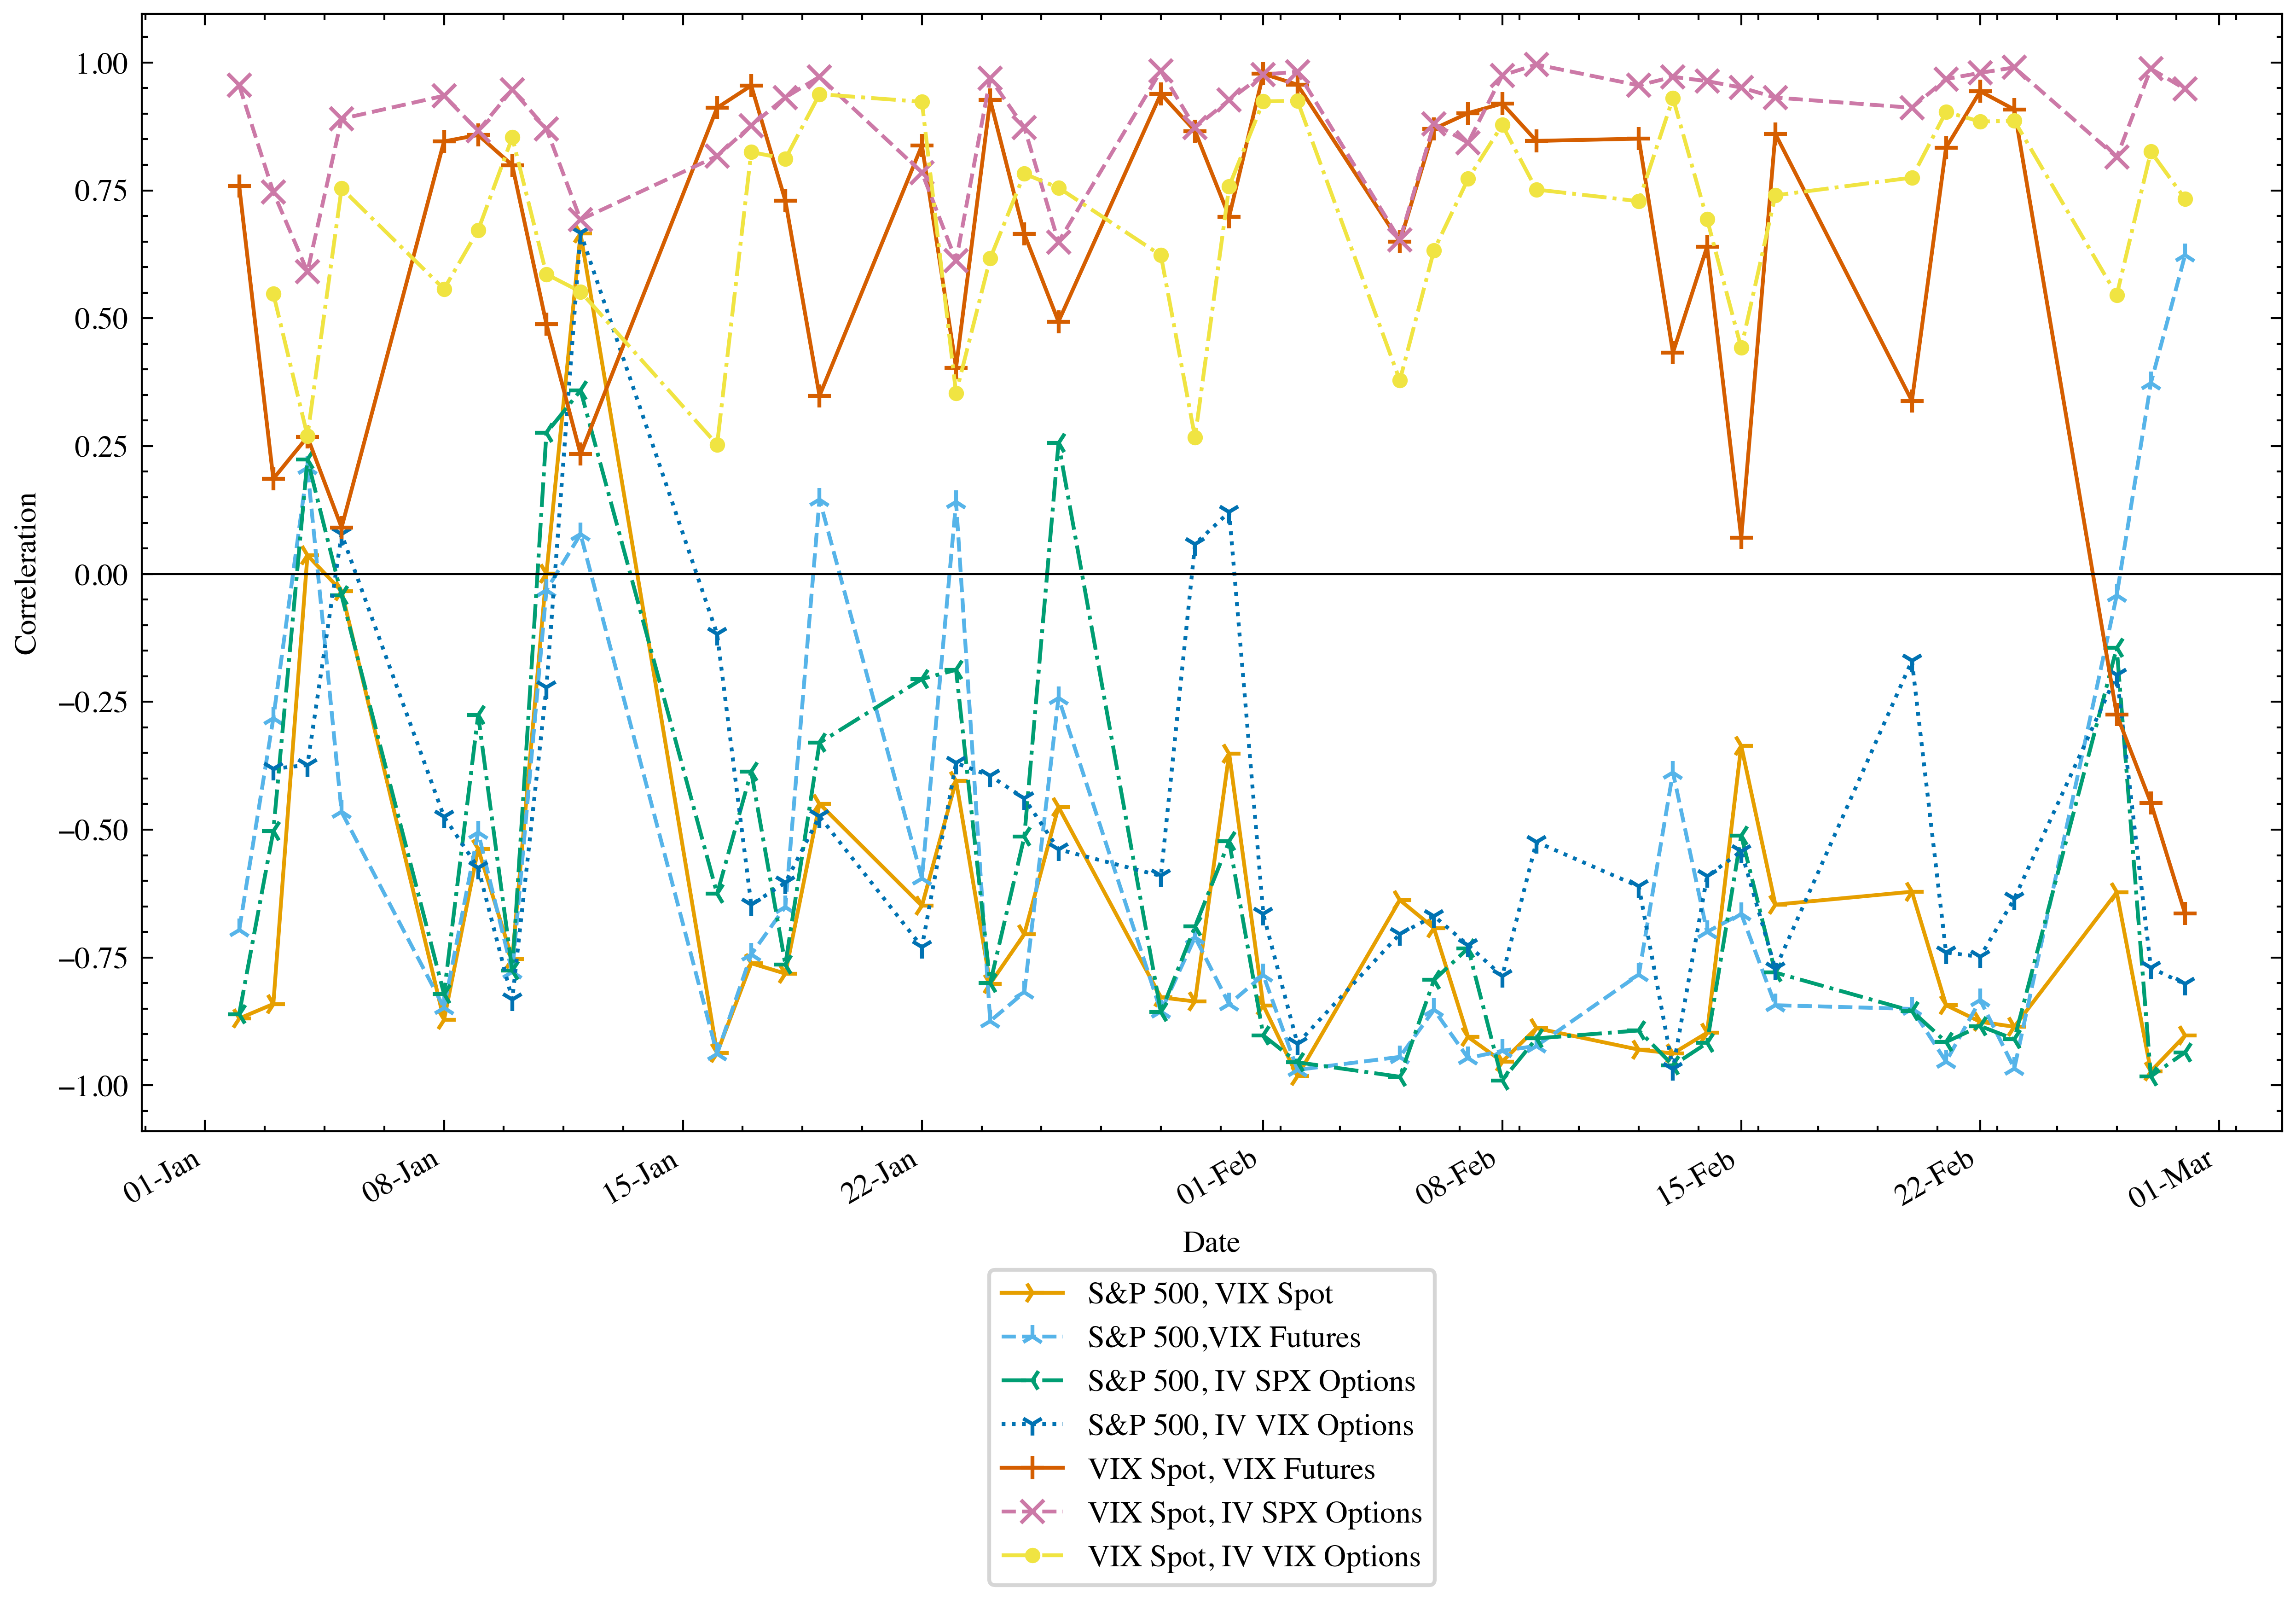

In [303]:
DrawDataFrame4(CorrelationAB)

#### Produce one table (Table 2) which contains the same information like on page 32 Shu and Zhang “Table 2”

### $\log(strike / price)$

In [304]:
def GetRowData(df):
    TemA = df
    resultRow = []
    resultRow.append(len(TemA))
    resultRow.append(len(TemA[np.sign(TemA['SP500 price']) != np.sign(TemA['IV SPX'])]))
    resultRow.append(len(TemA[np.sign(TemA['SP500 price']) != np.sign(TemA['IV VIX'])]))
    resultRow.append(len(TemA[np.sign(TemA['SP500 price']) != np.sign(TemA['vix_spot'])]))
    resultRow.append(len(TemA[np.sign(TemA['SP500 price']) != np.sign(TemA['VIX FUTURE'])]))
    ret = pd.DataFrame([resultRow])
    return ret

In [307]:
def GetDataForTable2(df):
    df1 = df    
    ret = pd.DataFrame()
    ret = pd.concat([ret, GetRowData(df1[df1['SP500 price'] < -0.003])])
    ret = pd.concat([ret, GetRowData(df1[(df1['SP500 price'] >= -0.003) & (df1['SP500 price'] < -0.001)])])
    ret = pd.concat([ret, GetRowData(df1[(df1['SP500 price'] >= -0.001) & (df1['SP500 price'] < 0)])])
    ret = pd.concat([ret, GetRowData(df1[(df1['SP500 price'] >= 0) & (df1['SP500 price'] < 0.001)])])
    ret = pd.concat([ret, GetRowData(df1[(df1['SP500 price'] > 0.001) & (df1['SP500 price'] < 0.003)])])
    ret = pd.concat([ret, GetRowData(df1[(df1['SP500 price'] > 0.003)])])
    ret.index = ['>-3%', '-3% ~ -1%', '-1% ~ 0%', '0% ~ 1%', '1% ~ 3%', '3%<']
    ret.columns = ['Total', 'Negative Direction with IV SPX', 'Negative Direction with IV VIX', 'Negative Direction with  VIX', 'Negative Direction with  VIX Future']
    return ret

In [312]:
returnTotalTableA =lock1 

In [313]:
returnTotalTableA

SP500 price  vix_spot  VIX FUTURE  IV VIX  IV SPX  sig_x  \
DATETIME                                                                        
2018-01-02 08:00:00       -0.000     0.067       0.007     nan   0.048 -0.045   
2018-01-02 09:00:00       -0.001     0.012       0.000     nan   0.014 -0.048   
2018-01-02 10:00:00        0.001    -0.004       0.004     nan   0.014 -0.050   
2018-01-02 11:00:00        0.000     0.000       0.000     nan   0.004 -0.049   
2018-01-02 12:00:00       -0.000     0.014      -0.000     nan   0.013 -0.050   
...                          ...       ...         ...     ...     ...    ...   
2018-02-28 11:00:00       -0.002     0.037       0.004   0.174   0.052  0.019   
2018-02-28 12:00:00       -0.001     0.014       0.004   0.209   0.007  0.012   
2018-02-28 13:00:00        0.006    -0.046       0.004  -0.138  -0.050  0.011   
2018-02-28 14:00:00        0.008    -0.057       0.011  -0.125  -0.057  0.019   
2018-02-28 15:00:00        0.000     0.036      -0.013  -0.077   0.035  0.029   

                     tem_x  sig_y  tem_y    sig   tem  
DATETIME                                               
2018-01-02 08:00:00  0.000 -0.048  0.000  0.044 0.000  
2018-01-02 09:00:00  0.000 -0.049  0.000  0.011 0.000  
2018-01-02 10:00:00  0.000 -0.051  0.000  0.010 0.000  
2018-01-02 11:00:00  0.000 -0.050  0.000 -0.000 0.000  
2018-01-02 12:00:00  0.000 -0.051  0.000  0.009 0.000  
...                    ...    ...    ...    ...   ...  
2018-02-28 11:00:00  0.000  0.012  0.000  0.048 0.000  
2018-02-28 12:00:00  0.000  0.012  0.000  0.003 0.000  
2018-02-28 13:00:00  0.000  0.018  0.000 -0.054 0.000  
2018-02-28 14:00:00  0.000  0.027  0.000 -0.060 0.000  
2018-02-28 15:00:00  0.000  0.024  0.000  0.031 0.000  

[312 rows x 11 columns]

In [314]:
returnTotalTableA = returnTotalTableA.append(returnTotalTableB)
returnTotalTableA

SP500 price  vix_spot  VIX FUTURE  IV VIX  IV SPX  sig_x  \
DATETIME                                                                        
2018-01-02 08:00:00       -0.000     0.067       0.007     nan   0.048 -0.045   
2018-01-02 09:00:00       -0.001     0.012       0.000     nan   0.014 -0.048   
2018-01-02 10:00:00        0.001    -0.004       0.004     nan   0.014 -0.050   
2018-01-02 11:00:00        0.000     0.000       0.000     nan   0.004 -0.049   
2018-01-02 12:00:00       -0.000     0.014      -0.000     nan   0.013 -0.050   
...                          ...       ...         ...     ...     ...    ...   
2018-02-05 11:00:00        0.004    -0.023      -0.045  -0.136  -0.065 -0.031   
2018-02-05 12:00:00        0.003    -0.065      -0.028  -0.245  -0.058 -0.020   
2018-02-05 13:00:00        0.014     0.008      -0.123  -0.165  -0.245 -0.013   
2018-02-05 14:00:00        0.011    -0.085      -0.140  -0.235  -0.211  0.043   
2018-02-05 15:00:00       -0.000    -0.063      -0.221  -0.007  -0.103  0.100   

                     tem_x  sig_y  tem_y    sig   tem  
DATETIME                                               
2018-01-02 08:00:00  0.000 -0.048  0.000  0.044 0.000  
2018-01-02 09:00:00  0.000 -0.049  0.000  0.011 0.000  
2018-01-02 10:00:00  0.000 -0.051  0.000  0.010 0.000  
2018-01-02 11:00:00  0.000 -0.050  0.000 -0.000 0.000  
2018-01-02 12:00:00  0.000 -0.051  0.000  0.009 0.000  
...                    ...    ...    ...    ...   ...  
2018-02-05 11:00:00  0.000 -0.020  0.000  0.010 0.000  
2018-02-05 12:00:00  0.000 -0.010  0.000  0.016 0.000  
2018-02-05 13:00:00  0.000  0.040  0.000 -0.171 0.001  
2018-02-05 14:00:00  0.000  0.102  0.000 -0.137 0.000  
2018-02-05 15:00:00  0.000  0.131  0.000 -0.028 0.000  

[320 rows x 11 columns]

In [315]:
table2DataA = GetDataForTable2(returnTotalTableA)
table2DataB = GetDataForTable2(returnTotalTableB)
display_side_by_side(table2DataA, table2DataB, titles=['No. of Observation A','No. of Observation B'], TotalTitle = 'Table 2')


Table 2 No. of Observation A 
 
 
 
 Total 
 Negative Direction with IV SPX 
 Negative Direction with IV VIX 
 Negative Direction with VIX 
 Negative Direction with VIX Future 
 
 
 
 
 >-3% 
 29 
 27 
 25 
 25 
 25 
 
 
 -3% ~ -1% 
 64 
 47 
 50 
 49 
 47 
 
 
 -1% ~ 0% 
 86 
 52 
 59 
 53 
 49 
 
 
 0% ~ 1% 
 64 
 34 
 40 
 40 
 30 
 
 
 1% ~ 3% 
 46 
 37 
 29 
 39 
 37 
 
 
 3%< 
 31 
 29 
 27 
 30 
 26 
 
 
 No. of Observation B 
 
 
 
 Total 
 Negative Direction with IV SPX 
 Negative Direction with IV VIX 
 Negative Direction with VIX 
 Negative Direction with VIX Future 
 
 
 
 
 >-3% 
 2 
 2 
 1 
 1 
 2 
 
 
 -3% ~ -1% 
 0 
 0 
 0 
 0 
 0 
 
 
 -1% ~ 0% 
 1 
 0 
 0 
 0 
 0 
 
 
 0% ~ 1% 
 0 
 0 
 0 
 0 
 0 
 
 
 1% ~ 3% 
 1 
 1 
 1 
 1 
 1 
 
 
 3%< 
 4 
 4 
 4 
 3 
 4

In [316]:
table2DataA.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/table3.csv')

#### Produce one table (Table 3) which contains the same information like on page 34 Shu and Zhang “Table 3”. This table should have 2 sub-tables. One sub-table for each of our 2 time periods 1.Jan-28.Feb excluding 5.Feb and 5.Feb

### $F_{t}=\beta_0+\beta_1S_t+\epsilon_t$
### $ \Delta F_{i,t}=\alpha_0+\alpha_1F_{i,t-1}+ \sum_{j=1}^{p} \gamma_j \Delta F_{i,t-j}+\epsilon_{i,t},$
### $ \Delta F_{i,t}=\alpha_0+\alpha_1F_{i,t-1}+\alpha_2t+ \sum_{j=1}^{p} \gamma_j \Delta F_{i,t-j}+\epsilon_{i,t},i=0,1,2,3,4,$

In [318]:
def firstdifference(df):
    df1 = [0 for x in range(0, len(df))]
    for i in range(0, len(df)):
        if i == 0:
            df1[i] = 0
        else:
            df1[i] = df.iloc[i] - df.iloc[i - 1]
    return df1

In [319]:
def GetAdFuller(df, field):#
    dfTem = df
    ret1 = adfuller(dfTem[field].dropna(), maxlag=8, autolag=None, regression='nc' )
    ret2 = adfuller(dfTem[field].dropna(), maxlag=8, autolag=None, regression='ct' )
    
    df1 = dfTem[field].diff().dropna()#firstdifference(dfTem[field].dropna())
    #print(df1)
    ret3 = adfuller(df1, maxlag=8, autolag=None, regression='nc' )
    ret4 = adfuller(df1, maxlag=8, autolag=None, regression='ct' )
    
    row1 = pd.DataFrame([[ret1[0], ret1[4]['5%']]])
    row2 = pd.DataFrame([[ret2[0], ret2[4]['5%']]])
    
    row3 = pd.DataFrame([[ret3[0], ret3[4]['5%']]])
    row4 = pd.DataFrame([[ret4[0], ret4[4]['5%']]])
    
    dfPanelA = pd.concat([row1, row2])
    dfPanelB = pd.concat([row3, row4])
    
    dfPanelA.columns = [field, 'Critical Value']
    dfPanelB.columns = [field, 'Critical Value']
    
    dfPanelA.index = ['Without trend', 'With trend']
    dfPanelB.index = ['Without trend', 'With trend']
    
    
    return [dfPanelA, dfPanelB]

In [329]:
listTemColumns = listColumns.copy()
dfTable31 = pd.DataFrame()
dfTable32 = pd.DataFrame()
dfP_A = pd.DataFrame()
dfP_B = pd.DataFrame()
for i in listTemColumns:
    [dfP_A, dfP_B] = GetAdFuller(dfTotalTableA, i)
    dfTable31 = pd.concat([dfTable31, dfP_A[i]], axis=1)
    dfTable32 = pd.concat([dfTable32, dfP_B[i]], axis=1)
dfTable31 = pd.concat([dfTable31, dfP_A['Critical Value']], axis=1)
dfTable32 = pd.concat([dfTable32, dfP_B['Critical Value']], axis=1)

display_side_by_side(dfTable31, dfTable32, titles=['Panel A: Unit root tests on price levels','Panel B: Unit root tests on the first difference'], TotalTitle = 'Table 3 (A)')

Table 3 (A) Panel A: Unit root tests on price levels 
 
 
 
 SP500 price 
 vix_spot 
 VIX FUTURE 
 IV VIX 
 IV SPX 
 Critical Value 
 
 
 
 
 Without trend 
 0.099 
 -0.401 
 -0.279 
 -4.523 
 -0.842 
 -1.941 
 
 
 With trend 
 -1.965 
 -2.583 
 -3.570 
 -8.350 
 -3.809 
 -3.411 
 
 
 Panel B: Unit root tests on the first difference 
 
 
 
 SP500 price 
 vix_spot 
 VIX FUTURE 
 IV VIX 
 IV SPX 
 Critical Value 
 
 
 
 
 Without trend 
 -44.374 
 -41.293 
 -44.520 
 -45.975 
 -42.435 
 -1.941 
 
 
 With trend 
 -44.382 
 -41.293 
 -44.518 
 -45.972 
 -42.433 
 -3.411

In [425]:
dfTable31.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/dfTable31.csv')
dfTable32.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/dfTable32.csv')

In [330]:
listTemColumns = listColumns.copy()
dfTable31 = pd.DataFrame()
dfTable32 = pd.DataFrame()
dfP_A = pd.DataFrame()
dfP_B = pd.DataFrame()
for i in listTemColumns:
    [dfP_A, dfP_B] = GetAdFuller(dfTotalTableB, i)
    dfTable31 = pd.concat([dfTable31, dfP_A[i]], axis=1)
    dfTable32 = pd.concat([dfTable32, dfP_B[i]], axis=1)
dfTable31 = pd.concat([dfTable31, dfP_A['Critical Value']], axis=1)
dfTable32 = pd.concat([dfTable32, dfP_B['Critical Value']], axis=1)

display_side_by_side(dfTable31, dfTable32, titles=['Panel A: Unit root tests on price levels','Panel B: Unit root tests on the first difference'], TotalTitle = 'Table 3 (B)')

Table 3 (B) Panel A: Unit root tests on price levels 
 
 
 
 SP500 price 
 vix_spot 
 VIX FUTURE 
 IV VIX 
 IV SPX 
 Critical Value 
 
 
 
 
 Without trend 
 -2.076 
 0.538 
 1.927 
 -0.897 
 3.214 
 -1.942 
 
 
 With trend 
 -1.480 
 -3.991 
 2.109 
 -3.190 
 0.207 
 -3.422 
 
 
 Panel B: Unit root tests on the first difference 
 
 
 
 SP500 price 
 vix_spot 
 VIX FUTURE 
 IV VIX 
 IV SPX 
 Critical Value 
 
 
 
 
 Without trend 
 -6.797 
 -5.069 
 -2.452 
 -10.825 
 -7.048 
 -1.942 
 
 
 With trend 
 -7.429 
 -5.069 
 -3.355 
 -10.796 
 -8.325 
 -3.422

#### Produce one table (Table 4) which contains the same information like on page 35 Shu and Zhang “Table 4”. This table should have 2 sub-tables. One sub-table for each of our 2 time periods 1.Jan-28.Feb excluding 5.Feb and 5.Feb

### $F_{ti,}=\beta_0+\beta_1F_{j,t}+\epsilon_{i,t'}$
### $ \Delta \hat{\epsilon_{i,t}} = \alpha_0+\alpha_1 \hat{\epsilon_{i,t-1}} + \sum_{k=1}^{p} \gamma_j \Delta \hat{\epsilon_{t-k}}+v_t$ , i=0,1,2,3,4,  j=0,1,2,3,4 $i \ne j$ 

In [331]:
from statsmodels.tsa.stattools import coint
from statsmodels.sandbox.sysreg import SUR

In [332]:
def makedifference(df1):
    df = df1.copy()
    for colname in listColumns:
        df[colname] = firstdifference(df[colname])
    return df 

In [334]:
dfTotalTableAA = dfTotalTableA.drop(columns = ['sig', 'tem'])
dfTotalTableAA = dfTotalTableAA.dropna()#.diff()
#dfTotalTableAA['Replication VIX'] = dfTotalTableAA['Replication VIX'].diff()
#dfTotalTableAA['vix_spot'] = dfTotalTableAA['vix_spot'].diff()
#dfTotalTableAA['VIX FUTURE'] = dfTotalTableAA['VIX FUTURE'].diff()
#dfTotalTableAA['Replication VIX'] = dfTotalTableAA['Replication VIX'].diff()
#dfTotalTableAA['IV SPX'] = dfTotalTableAA['IV SPX'].diff()

#dfTotalTableAA = dfTotalTableAA.dropna()
dfTotalTableBB = dfTotalTableB.drop(columns = ['sig', 'tem'])
dfTotalTableBB = dfTotalTableBB.dropna()#.diff().dropna()
#dfTotalTableBB['vix_spot'] = dfTotalTableBB['vix_spot'].diff()
#dfTotalTableBB['VIX FUTURE'] = dfTotalTableBB['VIX FUTURE'].diff()
#dfTotalTableBB = dfTotalTableBB.dropna()

In [335]:
dfTotalTable4A = dfTotalTableAA#.diff().dropna()#dftempA.fillna(0)#dfTotalTableA.fillna(0)
dfTotalTable4B = dfTotalTableBB#.diff().dropna()#dftempB.fillna(0)#dfTotalTableB.fillna(0)

In [430]:
dfTotalTable4Adiff = makedifference(dfTotalTable4A)
dfTotalTable4Bdiff = makedifference(dfTotalTable4B)

In [339]:
def GetDataForTable4(df, listTemColumns):
    dfTableTem = df
    ret = pd.DataFrame()
    criticalvalue = 0
    indexlst = []
    for i in range(1, len(listTemColumns)):
        rowLst = []
        for j in range(i):
            coint_test = coint(dfTableTem[listTemColumns[i]], dfTableTem[listTemColumns[j]], trend='ct', autolag='AIC')
            criticalvalue = coint_test[2][1]
            rowLst.append(coint_test[0])
        dfTem = pd.DataFrame([rowLst])
        ret = pd.concat([ret, dfTem])
        indexlst.append(listTemColumns[i])
        #print('---')
    ret.index = indexlst
    lstColum = listTemColumns.copy()
    del lstColum[len(lstColum) - 1]
    ret.columns = lstColum
    print(criticalvalue)
    return ret

In [426]:
df = dfTotalTable4A
listTemColumns
dfTableTem = df
ret = pd.DataFrame()
criticalvalue = 0
indexlst = []
for i in range(1, len(listTemColumns)):
    rowLst = []
    for j in range(i):
        coint_test = coint(dfTableTem[listTemColumns[i]], dfTableTem[listTemColumns[j]], trend='ct', autolag='AIC')
        criticalvalue = coint_test[2][1]
        rowLst.append(coint_test[0])
    dfTem = pd.DataFrame([rowLst])
    ret = pd.concat([ret, dfTem])
    indexlst.append(listTemColumns[i])
    #print('---')
ret.index = indexlst
lstColum = listTemColumns.copy()
del lstColum[len(lstColum) - 1]
ret.columns = lstColum
coint_test


(-5.223512866885913, 0.00034308328589319914, array([-4.32863861, -3.78119744, -3.49677718]))


In [427]:
coint_test


(-5.223512866885913,
 0.00034308328589319914,
 array([-4.32863861, -3.78119744, -3.49677718]))

In [431]:
listTemColumns = listColumns.copy()
#del listTemColumns[3]
dfTable4A = GetDataForTable4(dfTotalTable4Adiff, listTemColumns)
dfTable4A = dfTable4A.fillna('')
display_side_by_side(dfTable4A, titles=['Cointegration Test for Pairs of VIX and VIX Futures Rolling Contracts For DataFrame A','Cointegration Test for Pairs of VIX and VIX Futures Rolling Contracts For DataFrame B'], TotalTitle = 'Table 4')

-3.7811974422119223


Table 4 Cointegration Test for Pairs of VIX and VIX Futures Rolling Contracts For DataFrame A 
 
 
 
 SP500 price 
 vix_spot 
 VIX FUTURE 
 IV VIX 
 
 
 
 
 vix_spot 
 -21.804 
 
 
 
 
 
 VIX FUTURE 
 -20.986 
 -20.178 
 
 
 
 
 IV VIX 
 -21.816 
 -21.060 
 -22.015 
 
 
 
 IV SPX 
 -23.901 
 -22.943 
 -24.212 
 -24.252

In [429]:
dfTable4A.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/dfTable4A.csv')

#### Produce one table (Table 5) which contains the same information like on page 39 Shu and Zhang “Table 5”. This table should have 2 sub-tables. One sub-table for each of our 2 time periods 1.Jan-28.Feb excluding 5.Feb and 5.Feb

### $ \Delta F_{i,t} = \delta_f+\alpha_f \hat{u_{i,t-1}}+\beta_f \Delta F_{j,t-1} + \gamma_f \Delta F_{i,t-1} + \epsilon_{f,t}$,
### $ \Delta F_{j,t} = \delta_s+\alpha_s \hat{u_{i,t-1}}+\beta_s \Delta F_{i,t-1}+\gamma_s \Delta F_{j,t-1}+\epsilon_{s,t}$,$i=$1, 2, 3, 4

In [345]:
from linearmodels.datasets import munnell
from collections import OrderedDict
from linearmodels.system import SUR

In [370]:
dfTotalTable5A = dfTotalTable4A.dropna()#dfTotalTableA.fillna(1)#dftempA.fillna(1)#
dfTotalTable5B = dfTotalTable4B.dropna()#.fillna(1)#dftempB.fillna(1)#


#dfTotalTable5A = dfTotalTable5A.loc[(dfTotalTable5A!=0).any(axis=1)]
#dfTotalTable5B = dfTotalTable5B.loc[(dfTotalTable5B!=0).any(axis=1)]

#dfTotalTable5A = dfTotalTable5A.dropna()
#dfTotalTable5B = dfTotalTable5B.dropna()

dfTotalTable5A = dfTotalTable5A.rename_axis('DATETIME').reset_index()
dfTotalTable5B = dfTotalTable5B.rename_axis('DATETIME').reset_index()

In [401]:
def GetModeDataFrame(df, field1, field2):
    dfPreData = df
    a0 = 0.0
    a1 = 1.0
    dfPreData['f'] = dfPreData[field1]
    dfPreData['u'] = 0.0
    dfPreData['_s'] = 0.0
    dfPreData['_f1'] = 0.0
    dfPreData['_f'] = 0.0
    #print(dfPreData[field1])

    for i in range(len(dfPreData)):
        if i == 0:
            dfPreData['_f'][0] = 0
            dfPreData['_s'][0] = 0
        else:
            #print((float(dfPreData[field1][i]) - float(dfPreData[field1][i - 1])) * 400)
            dfPreData['_f'][i] = (float(dfPreData[field1][i]) - float(dfPreData[field1][i - 1]))
            dfPreData['_s'][i] = (float(dfPreData[field2][i]) - float(dfPreData[field2][i - 1]))
            dfPreData['_f1'][i - 1] = float(dfPreData['_f'][i])
        dfPreData['u'][i] = float(dfPreData[field1][i]) - a0 - float(dfPreData[field2][i]) * a1
    
    dfPreData['_f1'][len(dfPreData) - 1] = 0
    
    
    ret = pd.concat([dfPreData['DATETIME'],dfPreData['f'], dfPreData['_f'], dfPreData['u'], dfPreData['_s'], dfPreData['_f1']], axis=1)
    return ret

def GetModData(df, field1, field2, mod_data):
    region_data = GetModeDataFrame(df, field1, field2)
    
    region_data = region_data.set_index('DATETIME')
    
    region_data['f'] = np.log(region_data['f'])
        
    dependent = region_data['f']
    
    #dependent = region_data['ln_f']
    region_data = region_data.drop(columns = ['f'])
    #print(dependent)

    #print(dependent)
    exog = region_data
    
    exog.columns = ["δ", "α", "β", "γ"]
    region = field1 + '_' + field2
    #print('----------- Dependent -------------')
    #print(dependent)
    #print('----------- exog -------------')
    #print(exog)
    mod_data[region] = {"dependent": dependent, "exog": exog}
    #mod_data = mod_data.loc[(mod_data!=0).any(axis=1)]
    #mod_data = mod_data.dropna()
    return mod_data

def GetParameterForTable5(df):
    dfT = df
    mod_data = OrderedDict()
    mod_data = GetModData(dfT, 'IV SPX', 'SP500 price', mod_data)
    mod_data = GetModData(dfT, 'IV SPX', 'vix_spot', mod_data)    
    mod_data = GetModData(dfT, 'vix_spot', 'IV SPX', mod_data)
    mod_data = GetModData(dfT, 'IV SPX', 'VIX FUTURE', mod_data)
    mod_data = GetModData(dfT, 'VIX FUTURE', 'IV SPX', mod_data)
    mod_data = GetModData(dfT, 'IV SPX', 'IV VIX', mod_data)
    mod_data = GetModData(dfT, 'SP500 price', 'vix_spot', mod_data)
    mod_data = GetModData(dfT, 'SP500 price', 'VIX FUTURE', mod_data)
    mod_data = GetModData(dfT, 'SP500 price', 'IV VIX', mod_data)
    mod_data = GetModData(dfT, 'SP500 price', 'IV SPX', mod_data)
    mod_data = GetModData(dfT, 'vix_spot', 'SP500 price', mod_data)
    mod_data = GetModData(dfT, 'vix_spot', 'VIX FUTURE', mod_data)
    mod_data = GetModData(dfT, 'vix_spot', 'IV VIX', mod_data)
    mod_data = GetModData(dfT, 'VIX FUTURE', 'SP500 price', mod_data)
    mod_data = GetModData(dfT, 'VIX FUTURE', 'vix_spot', mod_data)
    mod_data = GetModData(dfT, 'VIX FUTURE', 'IV VIX', mod_data)

    mod = SUR(mod_data)
    
    res = mod.fit(cov_type="robust")
    #print(res)
    para1 = []
    for label in res.equation_labels:
        para1.append(res.equations[label].params)
    para1 = pd.concat(para1, 1)
    para1.columns = res.equation_labels
    #para1.T.style.format("{:0.5f}")
    
    res_ols = mod.fit(method="ols", debiased=True,cov_type="unadjusted")
    para2 = []
    r2 = []
    for label in res.equation_labels:
        para2.append(res_ols.equations[label].params)
        r2.append(res_ols.equations[label].rsquared)
    para2 = pd.concat(para2, 1)
    para2.columns = res.equation_labels
    para2 = para2.T
    para2["R2"] = r2
    #para2.style.format("{:0.5f}")
    
    return [para1, para2]

def GetTable5(param1, param2, field, index):
    ret = pd.DataFrame()
    #print('_' + field + '_')
    dffTem2 = pd.DataFrame([param2.iloc[index]])
    ret = pd.concat([ret, dffTem2])
    #print(params2[field])
    dffTem1 = pd.DataFrame([param1[field]])
    ret = pd.concat([ret, dffTem1])
    ret.index = ['col1', '']
    ret['R2'] = ret['R2'].fillna('')
    return ret

def display_side_by_side5(param1, param2, TotalTitle):
    html_str=''
    html_str+=f'<div><h2>{TotalTitle}</h2></div>'

    lstinf = ['IV SPX_SP500 price', 'IV SPX_vix_spot', 'IV SPX_VIX FUTURE','IV SPX_IV VIX', 'SP500 price_vix_spot', 'SP500 price_VIX FUTURE', 'SP500 price_IV SPX', 'SP500 price_IV VIX', 'vix_spot_SP500 price', 'vix_spot_VIX FUTURE', 'vix_spot_IV SPX', 'vix_spot_IV VIX', 'VIX FUTURE_SP500 price', 'VIX FUTURE_vix_spot', 'VIX FUTURE_IV SPX', 'VIX FUTURE_IV VIX']
    #lstinf = ['IV SPX_vix_spot', 'vix_spot_IV SPX', 'IV SPX_VIX FUTURE', 'VIX FUTURE_IV SPX', 'vix_spot_VIX FUTURE', 'VIX FUTURE_vix_spot']
    for i in range(0, len(lstinf),2):
        df1 = GetTable5(param1, param2, lstinf[i], i)
        df1 = df1.rename(index={'col1':'EQ(T1)'})
        df2 = GetTable5(param1, param2, lstinf[i + 1], i + 1)
        df2 = df2.rename(index={'col1':'EQ(T2)'})
        df = pd.concat([df1, df2])
        subtitle = 'Relation between ' + lstinf[i]
        html_str+='<div><th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h6>{subtitle}</h6>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        
        html_str+='</td></th></div>'
    display_html(html_str,raw=True)

In [411]:
dfTotalTable5B = pd.read_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/dfTotalTable5B.csv')

In [412]:
#[paramsA1, paramsA2] = GetParameterForTable5(dfTotalTable5A)
[paramsB1, paramsB2] = GetParameterForTable5(dfTotalTable5B)

In [414]:
paramsB1.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/paramsB1.csv')
paramsB2.to_csv('/Users/kiafarokhnia/Home/Publication/Notebook/Data/Produced_data/paramsB2.csv')

In [389]:
lstinf = ['IV SPX_SP500 price', 'IV SPX_vix_spot', 'IV SPX_VIX FUTURE','IV SPX_IV VIX', 'SP500 price_vix_spot', 'SP500 price_VIX FUTURE', 'SP500 price_IV SPX', 'SP500 price_IV VIX', 'vix_spot_SP500 price', 'vix_spot_VIX FUTURE', 'vix_spot_IV SPX', 'vix_spot_IV VIX', 'VIX FUTURE_SP500 price', 'VIX FUTURE_vix_spot', 'VIX FUTURE_IV SPX', 'VIX FUTURE_IV VIX']

for i in range(0, len(lstinf), 1):
        df1 = GetTable5(paramsA1, paramsA2, lstinf[i], i)
        df1 = df1.rename(index={'col1':'EQ(T1)'})
        try:
                df2 = GetTable5(paramsB1, paramsB2, lstinf[i + 1], i + 1)
                df2 = df2.rename(index={'col1':'EQ(T2)'})
        except:
                pass
        df = pd.concat([df1, df2])

df

δ     α     β      γ    R2
EQ(T1) -0.044 0.189 0.098  0.063 0.982
       -0.062 0.189 0.092  0.000      
EQ(T2) -0.269 0.195 0.092 -0.114 0.984
       -0.132 0.196 0.105 -0.004

In [403]:
display_side_by_side5(paramsA1, paramsA2, TotalTitle = 'Table 5 for DataFrame A')

Table 5 for DataFrame A Relation between IV SPX_SP500 price 
 
 
 
 δ 
 α 
 β 
 γ 
 R2 
 
 
 
 
 EQ(T1) 
 -3.815 
 0.001 
 -0.007 
 -2.232 
 0.980 
 
 
 
 2.754 
 0.001 
 0.001 
 -0.358 
 
 
 
 EQ(T2) 
 -3.245 
 0.111 
 0.107 
 -8.525 
 0.742 
 
 
 
 3.610 
 0.111 
 0.052 
 -0.381 
 
 
 
 Relation between IV SPX_VIX FUTURE 
 
 
 
 δ 
 α 
 β 
 γ 
 R2 
 
 
 
 
 EQ(T1) 
 -0.075 
 0.156 
 2.058 
 0.066 
 0.939 
 
 
 
 3.781 
 0.133 
 0.064 
 -0.366 
 
 
 
 EQ(T2) 
 1.136 
 0.133 
 0.079 
 -6.280 
 0.875 
 
 
 
 11.468 
 1.130 
 0.549 
 -0.371 
 
 
 
 Relation between SP500 price_vix_spot 
 
 
 
 δ 
 α 
 β 
 γ 
 R2 
 
 
 
 
 EQ(T1) 
 -0.061 
 0.175 
 0.075 
 0.059 
 0.981 
 
 
 
 -0.002 
 0.003 
 0.001 
 0.000 
 
 
 
 EQ(T2) 
 11.337 
 1.132 
 0.541 
 -14.026 
 0.524 
 
 
 
 -0.002 
 0.003 
 0.001 
 0.000 
 
 
 
 Relation between SP500 price_IV SPX 
 
 
 
 δ 
 α 
 β 
 γ 
 R2 
 
 
 
 
 EQ(T1) 
 -0.002 
 0.003 
 -0.009 
 0.001 
 1.000 
 
 
 
 -0.002 
 0.003 
 -0.023 
 0.000 
 
 
 
 EQ(T2) 
 -0.002 
 0.003 
 -0.004 
 0.001 
 1.000 
 
 
 
 -0.002 
 0.003 
 0.001 
 0.000 
 
 
 
 Relation between vix_spot_SP500 price 
 
 
 
 δ 
 α 
 β 
 γ 
 R2 
 
 
 
 
 EQ(T1) 
 -0.001 
 0.003 
 -0.001 
 0.001 
 1.000 
 
 
 
 0.021 
 -0.001 
 -0.001 
 0.001 
 
 
 
 EQ(T2) 
 -0.002 
 0.003 
 -1.105 
 0.001 
 1.000 
 
 
 
 -0.088 
 0.234 
 0.112 
 0.001 
 
 
 
 Relation between vix_spot_IV SPX 
 
 
 
 δ 
 α 
 β 
 γ 
 R2 
 
 
 
 
 EQ(T1) 
 -0.028 
 -0.001 
 -0.006 
 -0.029 
 0.977 
 
 
 
 -0.052 
 0.156 
 -1.204 
 0.001 
 
 
 
 EQ(T2) 
 -0.037 
 0.235 
 0.120 
 0.100 
 0.098 
 
 
 
 -0.058 
 0.168 
 0.082 
 0.001 
 
 
 
 Relation between VIX FUTURE_SP500 price 
 
 
 
 δ 
 α 
 β 
 γ 
 R2 
 
 
 
 
 EQ(T1) 
 -0.046 
 0.168 
 0.086 
 0.056 
 0.940 
 
 
 
 0.029 
 -0.001 
 -0.001 
 -0.000 
 
 
 
 EQ(T2) 
 0.015 
 -0.001 
 -0.002 
 -0.034 
 0.991 
 
 
 
 0.117 
 -0.185 
 -0.085 
 0.000 
 
 
 
 Relation between VIX FUTURE_IV SPX 
 
 
 
 δ 
 α 
 β 
 γ 
 R2 
 
 
 
 
 EQ(T1) 
 0.130 
 -0.185 
 -0.032 
 0.010 
 0.062 
 
 
 
 -0.056 
 0.175 
 -1.351 
 0.000 
 
 
 
 EQ(T2) 
 -0.044 
 0.189 
 0.098 
 0.063 
 0.982 
 
 
 
 -0.062 
 0.189 
 0.092 
 0.000

In [413]:
display_side_by_side5(paramsB1, paramsB2, TotalTitle = 'Table 5 for DataFrame B')

Table 5 for DataFrame B Relation between IV SPX_SP500 price 
 
 
 
 δ 
 α 
 β 
 γ 
 R2 
 
 
 
 
 EQ(T1) 
 7.614 
 0.001 
 -0.002 
 4.933 
 0.989 
 
 
 
 2.075 
 0.001 
 -0.001 
 -0.159 
 
 
 
 EQ(T2) 
 16.348 
 0.075 
 0.109 
 13.850 
 0.881 
 
 
 
 3.148 
 0.075 
 0.039 
 0.364 
 
 
 
 Relation between IV SPX_VIX FUTURE 
 
 
 
 δ 
 α 
 β 
 γ 
 R2 
 
 
 
 
 EQ(T1) 
 -0.100 
 0.136 
 -8.786 
 -0.006 
 0.973 
 
 
 
 2.386 
 0.098 
 0.097 
 -1.076 
 
 
 
 EQ(T2) 
 9.771 
 0.098 
 0.318 
 -3.722 
 0.934 
 
 
 
 6.538 
 0.333 
 0.160 
 -1.565 
 
 
 
 Relation between SP500 price_vix_spot 
 
 
 
 δ 
 α 
 β 
 γ 
 R2 
 
 
 
 
 EQ(T1) 
 -0.253 
 0.162 
 -3.892 
 -0.143 
 0.990 
 
 
 
 -0.002 
 0.003 
 0.002 
 0.001 
 
 
 
 EQ(T2) 
 6.868 
 0.330 
 0.161 
 2.151 
 0.510 
 
 
 
 -0.001 
 0.003 
 0.007 
 0.001 
 
 
 
 Relation between SP500 price_IV SPX 
 
 
 
 δ 
 α 
 β 
 γ 
 R2 
 
 
 
 
 EQ(T1) 
 -0.004 
 0.003 
 0.017 
 -0.002 
 1.000 
 
 
 
 -0.002 
 0.003 
 0.063 
 0.001 
 
 
 
 EQ(T2) 
 -0.002 
 0.003 
 0.045 
 -0.000 
 1.000 
 
 
 
 -0.002 
 0.003 
 0.001 
 0.001 
 
 
 
 Relation between vix_spot_SP500 price 
 
 
 
 δ 
 α 
 β 
 γ 
 R2 
 
 
 
 
 EQ(T1) 
 -0.004 
 0.003 
 0.003 
 -0.001 
 1.000 
 
 
 
 0.019 
 -0.001 
 -0.001 
 0.004 
 
 
 
 EQ(T2) 
 -0.003 
 0.003 
 1.776 
 -0.001 
 1.000 
 
 
 
 -0.189 
 0.506 
 0.402 
 0.040 
 
 
 
 Relation between vix_spot_IV SPX 
 
 
 
 δ 
 α 
 β 
 γ 
 R2 
 
 
 
 
 EQ(T1) 
 0.057 
 -0.001 
 -0.006 
 0.027 
 0.993 
 
 
 
 -0.050 
 0.136 
 -0.416 
 0.001 
 
 
 
 EQ(T2) 
 -0.187 
 0.507 
 0.244 
 0.209 
 0.740 
 
 
 
 -0.073 
 0.161 
 0.077 
 -0.011 
 
 
 
 Relation between VIX FUTURE_SP500 price 
 
 
 
 δ 
 α 
 β 
 γ 
 R2 
 
 
 
 
 EQ(T1) 
 -0.207 
 0.160 
 0.046 
 -0.071 
 0.983 
 
 
 
 0.041 
 -0.001 
 -0.001 
 0.006 
 
 
 
 EQ(T2) 
 0.134 
 -0.001 
 0.000 
 0.095 
 0.997 
 
 
 
 0.379 
 -0.468 
 -0.207 
 -0.014 
 
 
 
 Relation between VIX FUTURE_IV SPX 
 
 
 
 δ 
 α 
 β 
 γ 
 R2 
 
 
 
 
 EQ(T1) 
 0.266 
 -0.468 
 -0.210 
 -0.180 
 0.713 
 
 
 
 -0.115 
 0.163 
 -0.360 
 -0.009 
 
 
 
 EQ(T2) 
 -0.269 
 0.195 
 0.092 
 -0.114 
 0.984 
 
 
 
 -0.134 
 0.198 
 0.098 
 -0.005

#### Produce one table (Table 6) which contains the same information like on page 41 Shu and Zhang “Table 6”. This table should have 2 sub-tables. One sub-table for each of our 2 time periods 1.Jan-28.Feb excluding 5.Feb and 5.Feb

### Pr($\rVert x_t^m-x_s^m\rVert < e \mid \rVert x_(t-l_x)^{l_x} - x_{s-l_x}^{l_x} \rVert<e,\rVert y_{t-l_y}^{l_y}-y_{s-l_y}^{l_y} \rVert<e$)=Pr($\rVert x_t^m-x_s^m \rVert<e \mid \rVert x_{t-l_x}^{l_x}-x_{s-l_x}^{l_x} \rVert<e$),
### C1($m+l_x,l_y,e$) = Pr( $ \rVert x_{t-l_x}^{m+l_x} - x_{s-l_x}^{m+l_x} \rVert <e, \rVert y_{t-l_y}^{l_y} - y_{s-l_y}^{l_y}  \rVert<e$ ),
### C2($l_x,l_y,e$) = Pr( $ \rVert x_{t-l_x}^{l_x} - x_{s-l_x}^{l_x} \rVert <e, \rVert y_{t-l_y}^{l_y} - y_{s-l_y}^{l_y}  \rVert<e$ ),
### C3($m+l_x,e$) = Pr( $ \rVert x_{t-l_x}^{m+l_x} - x_{s-l_x}^{m+l_x} \rVert <e$,
### C4($l_x,e$) = Pr( $ \rVert x_{t-l_x}^{l_x} - x_{s-l_x}^{l_x} \rVert <e<e$ ),
# $\frac {C1(m+l_x,l_y,e)}{C2(l_x,l_y,e)} = \frac {C3(m+l_x,e}{C4(l_x,e)}$
## C1$(m+l_x,l_y,e,n)= \frac{2}{n(n+1)} \sum_{t<s}^{}\sum_{}^{} I(x_{t-l_x}^{m+l_x}, x_{s-l_x}^{m+l_x}, e)\mathsf X I(y_{t-l_y}^{l_y}, y_{s-l_y}^{l_y}, e)$,
## C2$(l_x,l_y,e,n)= \frac{2}{n(n+1)} \sum_{t<s}^{}\sum_{}^{} I(x_{t-l_x}^{l_x}, x_{s-l_x}^{l_x}, e)\mathsf X I(y_{t-l_y}^{l_y}, y_{s-l_y}^{l_y}, e)$,
## C3$(m+l_x,e,n)= \frac{2}{n(n+1)} \sum_{t<s}^{}\sum_{}^{} I(x_{t-l_x}^{m+l_x}, x_{s-l_x}^{m+l_x}, e)$,
## C4$(l_x,e,n)= \frac{2}{n(n+1)} \sum_{t<s}^{}\sum_{}^{} I(x_{t-l_x}^{l_x}, x_{s-l_x}^{l_x}, e)$,
## $ t,s = max(l_x,l_y)+1,...T-m+1,n=T+1-m-max(l_x,l_y)$
# $ \sqrt{n} \left( \frac {C1(m+l_x,l_y,e,n)}{C2(l_x,l_y,e,n)} - \frac {C3(m+l_x,e,n)}{C4(l_x,e,n)} \right)~AN(0, \sigma^2(m,l_x,l_y,e)) $

In [415]:
dfTotalTable6A = dfTotalTableAA.copy()

In [416]:
dfTotalTable6A

SP500 price  vix_spot  VIX FUTURE  IV VIX  IV SPX
2018-01-03 08:31:00     2698.360     9.580      12.675   0.794   0.073
2018-01-03 08:32:00     2698.550     9.580      12.675   0.723   0.072
2018-01-03 08:33:00     2697.990     9.570      12.656   0.723   0.072
2018-01-03 08:34:00     2699.230     9.540      12.625   0.723   0.072
2018-01-03 08:35:00     2698.740     9.540      12.625   0.723   0.072
...                          ...       ...         ...     ...     ...
2018-02-28 15:10:00     2713.830    19.950      17.526   1.681   0.150
2018-02-28 15:11:00     2713.830    19.870      17.512   1.681   0.150
2018-02-28 15:12:00     2713.830    19.770      17.512   1.743   0.150
2018-02-28 15:13:00     2713.830    19.780      17.462   1.743   0.150
2018-02-28 15:14:00     2713.830    19.700      17.513   1.718   0.149

[15160 rows x 5 columns]

In [419]:
#dfTotalTable6A['SP500 price'] =(dfTotalTable6A['SP500 price'] - dfTable1_A['SP500 price']['mean'])
dfTotalTable6A['vix_spot'] =(dfTotalTable6A['vix_spot'] - dfTable1_A['vix_spot']['mean'])
dfTotalTable6A['VIX FUTURE'] =(dfTotalTable6A['VIX FUTURE'] - dfTable1_A['VIX FUTURE']['mean'])
#dfTotalTable6A['IV VIX'] =(dfTotalTable6A['IV VIX'] - dfTable1_A['IV VIX']['mean'])
dfTotalTable6A['IV SPX'] =(dfTotalTable6A['IV SPX'] - dfTable1_A['IV SPX']['mean'])

#dfTotalTable6B['SP500 price'] =(dfTotalTable6B['SP500 price'] - dfTable1_B['SP500 price']['mean'])
#dfTotalTable6B['vix_spot'] =(dfTotalTable6B['vix_spot'] - dfTable1_B['vix_spot']['mean'])
#dfTotalTable6B['VIX FUTURE'] =(dfTotalTable6B['VIX FUTURE'] - dfTable1_B['VIX FUTURE']['mean'])
#dfTotalTable6B['IV VIX'] =(dfTotalTable6B['IV VIX'] - dfTable1_B['IV VIX']['mean'])
#dfTotalTable6B['IV SPX'] =(dfTotalTable6B['IV SPX'] - dfTable1_B['IV SPX']['mean'])

dfTotalTable6A = dfTotalTable6A.fillna(1000000)
#dfTotalTable6B = dfTotalTable6B.fillna(1000000)

In [422]:
def GetMaxSigma(df, field1, field2, index):
    dfTem = df
    nLen = len(dfTem)
    sumV = 0.0
    maxV = 0.0
    nn = 0
    for i in range(nLen):
        if(i + index >= nLen):
            break
        if (dfTem[field1][i + index] == 1000000) | (dfTem[field2][i] == 1000000):
            #print(i)
            continue
        #print(str(dfTem[field1][i + index]) + '-' + str(dfTem[field1][i]))
        temV = abs(dfTem[field1][i + index] - dfTem[field2][i])
        sumV = sumV + temV
        nn = nn + 1
        if maxV < temV:
            maxV = temV
    return [maxV / nn, sumV / nn]

def GetLeadTable6(df, field1, field2):
    dfTem = df
    ret = pd.DataFrame()
    for i in range(4):
        df1 = pd.DataFrame([GetMaxSigma(dfTem, field1, field2, i)])
        ret = pd.concat([ret, df1])
    ret.columns = ['CS', 'TVAL']
    ret.index = ['1', '2', '3', '4']
    return ret

def display_side_by_side6(df, TotalTitle):
    dfTem = df
    html_str=''
    html_str+=f'<div><h2>{TotalTitle}</h2></div>'
    lstinf = ['vix_spot', 'VIX FUTURE', 'IV SPX','IV VIX', 'SP500 price'] 
    for i in range(len(lstinf)):
        for j in range(i + 1, len(lstinf)):
            if i == j:
                continue
            df = GetLeadTable6(dfTem, lstinf[i], lstinf[j])
            subtitle = lstinf[i] + ' and ' + lstinf[j]
            html_str+='<div><th style="text-align:center"><td style="vertical-align:top">'
            html_str+=f'<h6>{subtitle}</h6>'
            html_str+=df.to_html().replace('table','table style="display:inline"')
            html_str+='</td></th></div>'
    display_html(html_str,raw=True)

In [423]:
display_side_by_side6(dfTotalTable6A, TotalTitle = 'Table 6 for Dataframe A')

Table 6 for Dataframe A vix_spot and VIX FUTURE 
 
 
 
 CS 
 TVAL 
 
 
 
 
 1 
 0.001 
 3.092 
 
 
 2 
 0.001 
 3.091 
 
 
 3 
 0.001 
 3.092 
 
 
 4 
 0.001 
 3.092 
 
 
 vix_spot and IV SPX 
 
 
 
 CS 
 TVAL 
 
 
 
 
 1 
 0.003 
 31.300 
 
 
 2 
 0.003 
 31.300 
 
 
 3 
 0.003 
 31.300 
 
 
 4 
 0.003 
 31.299 
 
 
 vix_spot and IV VIX 
 
 
 
 CS 
 TVAL 
 
 
 
 
 1 
 0.003 
 32.771 
 
 
 2 
 0.003 
 32.771 
 
 
 3 
 0.003 
 32.770 
 
 
 4 
 0.003 
 32.770 
 
 
 vix_spot and SP500 price 
 
 
 
 CS 
 TVAL 
 
 
 
 
 1 
 0.192 
 2787.844 
 
 
 2 
 0.192 
 2787.846 
 
 
 3 
 0.192 
 2787.848 
 
 
 4 
 0.192 
 2787.851 
 
 
 VIX FUTURE and IV SPX 
 
 
 
 CS 
 TVAL 
 
 
 
 
 1 
 0.002 
 29.831 
 
 
 2 
 0.002 
 29.831 
 
 
 3 
 0.002 
 29.830 
 
 
 4 
 0.002 
 29.830 
 
 
 VIX FUTURE and IV VIX 
 
 
 
 CS 
 TVAL 
 
 
 
 
 1 
 0.002 
 31.301 
 
 
 2 
 0.002 
 31.301 
 
 
 3 
 0.002 
 31.301 
 
 
 4 
 0.002 
 31.301 
 
 
 VIX FUTURE and SP500 price 
 
 
 
 CS 
 TVAL 
 
 
 
 
 1 
 0.192 
 2786.374 
 
 
 2 
 0.192 
 2786.377 
 
 
 3 
 0.192 
 2786.379 
 
 
 4 
 0.192 
 2786.382 
 
 
 IV SPX and IV VIX 
 
 
 
 CS 
 TVAL 
 
 
 
 
 1 
 0.001 
 1.471 
 
 
 2 
 0.001 
 1.471 
 
 
 3 
 0.001 
 1.471 
 
 
 4 
 0.001 
 1.471 
 
 
 IV SPX and SP500 price 
 
 
 
 CS 
 TVAL 
 
 
 
 
 1 
 0.190 
 2756.543 
 
 
 2 
 0.190 
 2756.546 
 
 
 3 
 0.190 
 2756.549 
 
 
 4 
 0.190 
 2756.552 
 
 
 IV VIX and SP500 price 
 
 
 
 CS 
 TVAL 
 
 
 
 
 1 
 0.189 
 2755.073 
 
 
 2 
 0.189 
 2755.075 
 
 
 3 
 0.189 
 2755.078 
 
 
 4 
 0.190 
 2755.081